# setup


In [ ]:
%%capture
!pip install prophet

## load s&co data

In [ ]:
# use v1.2 datasets; load from our repo for convenience
csv_urls = {
    'members': 'https://raw.githubusercontent.com/ZoeLeBlanc/unknown_borrowers/main/dataset_generator/source_data/SCoData_members_v1.2_2022-01.csv',
    'books': 'https://raw.githubusercontent.com/ZoeLeBlanc/unknown_borrowers/main/dataset_generator/source_data/SCoData_books_v1.2_2022-01.csv',
    'events': 'https://raw.githubusercontent.com/ZoeLeBlanc/unknown_borrowers/main/dataset_generator/source_data/SCoData_events_v1.2_2022-01.csv',
    # project-specific data
    'partial_borrowers': 'https://github.com/ZoeLeBlanc/unknown_borrowers/raw/main/dataset_generator/data/partial_borrowers_collapsed.csv',
    'borrow_overrides': 'https://raw.githubusercontent.com/ZoeLeBlanc/unknown_borrowers/main/dataset_generator/data/long_borrow_overrides.csv'
}

In [ ]:
import pandas as pd

# load events
events_df = pd.read_csv(csv_urls['events'])

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2882: DtypeWarning: Columns (20) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


## prepare logbook event data

In [ ]:
# identify to logbook events

logbook_events_df = events_df[events_df.source_type.str.contains('Logbook')][[
   'event_type', 'start_date', 'end_date', 'subscription_purchase_date',
   'member_uris', 'member_names',
   'subscription_duration', 'subscription_duration_days',
   'subscription_volumes', 'subscription_category',
   'source_type'
]]
# .dropna(subset=['start_date'])

logbook_events_df['start_date'] = pd.to_datetime(logbook_events_df['start_date'])
logbook_events_df['subscription_purchase_date'] = pd.to_datetime(logbook_events_df['subscription_purchase_date'])


In [ ]:
logbook_events_df.event_type.value_counts()

Renewal             4398
Subscription        4168
Reimbursement       2762
Supplement           190
Separate Payment      83
Name: event_type, dtype: int64

In [ ]:
logbook_events_df.source_type.value_counts()

Logbook                                              8324
Logbook;Address Book                                 2079
Logbook;Lending Library Card                         1077
Lending Library Card;Logbook                           59
Logbook;Lending Library Card;Address Book              54
Logbook;Lending Library Card;Lending Library Card       5
Logbook;Address Book;Lending Library Card               2
Lending Library Card;Logbook;Address Book               1
Name: source_type, dtype: int64

In [ ]:
# set logbook date; for subscriptions, the date recorded in the logbook is purchase date instead of start date
logbook_events_df['logbook_date'] = logbook_events_df.apply(lambda row: row.subscription_purchase_date if pd.notna(row.subscription_purchase_date) else row.start_date, axis=1)
logbook_events_df.dropna(subset=['logbook_date'])
logbook_events_df

event_type start_date  ...                   source_type logbook_date
17      Subscription 1925-01-01  ...                       Logbook   1925-01-01
114     Subscription 1934-01-01  ...                       Logbook   1934-01-01
433     Subscription 1930-05-01  ...          Logbook;Address Book   1930-05-01
671     Subscription 1919-11-17  ...  Lending Library Card;Logbook   1919-11-17
672     Subscription 1919-11-18  ...  Logbook;Lending Library Card   1919-11-18
...              ...        ...  ...                           ...          ...
35115        Renewal 1941-11-24  ...                       Logbook   1941-11-24
35116        Renewal 1941-12-04  ...                       Logbook   1941-12-04
35117  Reimbursement 1941-12-04  ...                       Logbook   1941-12-04
35118        Renewal 1941-12-08  ...                       Logbook   1941-12-08
35119        Renewal 1941-12-09  ...                       Logbook   1941-12-09

[11601 rows x 12 columns]

In [ ]:
# check non-logbook membership events
membership_events = events_df[events_df.event_type.isin(['Renewal', 'Subscription', 'Reimbursement' ,'Supplement', 'Separate Payment'])]
nonlogbook_membership_events = membership_events[~membership_events.source_type.str.contains('Logbook')]
nonlogbook_membership_events

event_type start_date  ... source_manifest source_image
1       Subscription       1921  ...             NaN          NaN
4       Subscription       1922  ...             NaN          NaN
6       Subscription       1923  ...             NaN          NaN
7       Subscription       1923  ...             NaN          NaN
9       Subscription       1923  ...             NaN          NaN
...              ...        ...  ...             ...          ...
35512  Reimbursement        NaN  ...             NaN          NaN
35517  Reimbursement        NaN  ...             NaN          NaN
35518  Reimbursement        NaN  ...             NaN          NaN
35520  Reimbursement        NaN  ...             NaN          NaN
35522  Reimbursement        NaN  ...             NaN          NaN

[1438 rows x 28 columns]

In [ ]:
membership_events.event_type.value_counts()

Subscription        4839
Renewal             4799
Reimbursement       3126
Supplement           190
Separate Payment      85
Name: event_type, dtype: int64

## calculate logbook gaps

In [ ]:
import requests

response = requests.get('https://raw.githubusercontent.com/ZoeLeBlanc/unknown_borrowers/main/missing-data-estimates/logbook-dates.json')
logbook_dates = response.json()
# these are the dates that are *covered* by the logbooks we have
logbook_dates

[{'endDate': '1923-12-31', 'startDate': '1919-11-17'},
 {'endDate': '1927-10-29', 'startDate': '1924-01-02'},
 {'endDate': '1927-12-31', 'startDate': '1927-11-02'},
 {'endDate': '1928-04-30', 'startDate': '1928-03-01'},
 {'endDate': '1928-12-31', 'startDate': '1928-05-01'},
 {'endDate': '1929-11-30', 'startDate': '1929-01-02'},
 {'endDate': '1930-01-02', 'startDate': '1929-12-02'},
 {'endDate': '1930-07-31', 'startDate': '1930-06-02'},
 {'endDate': '1931-02-16', 'startDate': '1931-01-01'},
 {'endDate': '1934-02-06', 'startDate': '1932-09-26'},
 {'endDate': '1934-12-31', 'startDate': '1934-02-09'},
 {'endDate': '1935-12-28', 'startDate': '1935-01-12'},
 {'endDate': '1936-12-31', 'startDate': '1936-01-02'},
 {'endDate': '1938-05-05', 'startDate': '1938-02-17'},
 {'endDate': '1939-08-28', 'startDate': '1938-10-21'},
 {'endDate': '1941-12-12', 'startDate': '1939-09-13'}]

In [ ]:
from datetime import timedelta

# adapted from KM's notebook

logbook_gaps = []
skipped_gaps = []

oneday = timedelta(days=1)


for i in range(len(logbook_dates) - 1):
  # gaps are between the logbook dates, so gap start is end of the first
  # and gap end is the start of the next

  # NOTE: adjusted from KM implementation: k
  # gap start and end dates are now included in the range instead of bounds outside the range
  gap_start = pd.to_datetime(logbook_dates[i]['endDate']) + oneday
  gap_end = pd.to_datetime(logbook_dates[i+1]['startDate']) - oneday
  interval = { 'start': gap_start, 'end': gap_end, 'days': (gap_end - gap_start).days }

  if interval['days'] > 12:
      logbook_gaps.append(interval) 
  elif interval['days'] > 0:  # ignore 0 and -1 duration "gaps"!
     skipped_gaps.append(interval)


print(f"The {len(logbook_gaps)} large gaps in the logbooks")
for interval in logbook_gaps:
    print(f"\t{interval['start'].strftime('%B %d %Y')} to {interval['end'].strftime('%B %d %Y')} ({interval['days']} days)")

print(f"\nThe {len(skipped_gaps)} small gaps in the logbooks that will be skipped")
for interval in skipped_gaps:
    print(f"\t{interval['start'].strftime('%B %d %Y')} to {interval['end'].strftime('%B %d %Y')} ({interval['days']} day{'s' if interval['days'] != 1 else ''})")

The 7 large gaps in the logbooks
	January 01 1928 to February 29 1928 (59 days)
	January 03 1930 to June 01 1930 (149 days)
	August 01 1930 to December 31 1930 (152 days)
	February 17 1931 to September 25 1932 (586 days)
	January 01 1937 to February 16 1938 (411 days)
	May 06 1938 to October 20 1938 (167 days)
	August 29 1939 to September 12 1939 (14 days)

The 4 small gaps in the logbooks that will be skipped
	October 30 1927 to November 01 1927 (2 days)
	February 07 1934 to February 08 1934 (1 day)
	January 01 1935 to January 11 1935 (10 days)
	December 29 1935 to January 01 1936 (3 days)


In [ ]:
# how many days total in the logbook gaps, the way I calculate them?
sum(gap['days'] for gap in logbook_gaps)

1538

In [ ]:
1.3 * 1538

1999.4

In [ ]:
# get logbook event data *except* for during gaps
# — v1.2 dataset has 9 stray events in these gaps; 8 misattributed to logbook source, one documented in a later logbook

logbook_events_nogaps = logbook_events_df.copy()

for i, gap in enumerate(logbook_gaps):
  gap_start = gap['start']
  gap_end = gap['end']
  logbook_events_nogaps = logbook_events_nogaps[~((logbook_events_nogaps.logbook_date >= gap_start) & (logbook_events_nogaps.logbook_date <= gap_end))]

logbook_events_nogaps

event_type start_date  ...                   source_type logbook_date
17      Subscription 1925-01-01  ...                       Logbook   1925-01-01
114     Subscription 1934-01-01  ...                       Logbook   1934-01-01
671     Subscription 1919-11-17  ...  Lending Library Card;Logbook   1919-11-17
672     Subscription 1919-11-18  ...  Logbook;Lending Library Card   1919-11-18
676     Subscription 1919-11-18  ...  Logbook;Lending Library Card   1919-11-18
...              ...        ...  ...                           ...          ...
35115        Renewal 1941-11-24  ...                       Logbook   1941-11-24
35116        Renewal 1941-12-04  ...                       Logbook   1941-12-04
35117  Reimbursement 1941-12-04  ...                       Logbook   1941-12-04
35118        Renewal 1941-12-08  ...                       Logbook   1941-12-08
35119        Renewal 1941-12-09  ...                       Logbook   1941-12-09

[11592 rows x 12 columns]

# missing membership events

## logbook / membership events by week

In [ ]:
logbooks_weekly_count = logbook_events_nogaps.groupby([pd.Grouper(key='logbook_date', freq='W')])['event_type'].count().reset_index()
logbooks_weekly_count.rename(columns={'event_type': 'total'}, inplace=True)
logbooks_weekly_count

logbook_date  total
0      1919-11-23     12
1      1919-11-30     12
2      1919-12-07     12
3      1919-12-14      6
4      1919-12-21      4
...           ...    ...
1186   1942-08-16      0
1187   1942-08-23      0
1188   1942-08-30      0
1189   1942-09-06      0
1190   1942-09-13      1

[1191 rows x 2 columns]

In [ ]:
# plot logbooks with no gaps to check logic

import altair as alt


base = alt.Chart(logbooks_weekly_count).encode(
    alt.X('logbook_date:T', axis=alt.Axis(title='date'))
).properties(
    width=1200,
    height=275
)

line = base.mark_line().encode(
    alt.Y('total',
          axis=alt.Axis(title='total events per week'))
)
line

# sns.set(rc = {'figure.figsize':(20,8)})

# fig, ax = plt.subplots(figsize=(20, 5))
# sns.lineplot(data=logbook_events_nogaps_monthly, x='logbook_date', y='total')

# for gap in logbook_gaps:
#   ax.axvspan(pd.to_datetime(gap['start']), pd.to_datetime(gap['end']), color="gray", alpha=0.3)

alt.Chart(...)

In [ ]:
logbook_gaps_df = pd.DataFrame(logbook_gaps)
logbook_gaps_df

start        end  days
0 1928-01-01 1928-02-29    59
1 1930-01-03 1930-06-01   149
2 1930-08-01 1930-12-31   152
3 1931-02-17 1932-09-25   586
4 1937-01-01 1938-02-16   411
5 1938-05-06 1938-10-20   167
6 1939-08-29 1939-09-12    14

In [ ]:
# draw rectangles to highlight logbook gaps
logbook_gaps_span = alt.Chart(logbook_gaps_df).encode(
     alt.X('start')
).properties(
    width=1200,
    height=300
).mark_rect(
    opacity=0.2, color="gray"
).encode(
    x='start',
    x2='end',
    y=alt.value(0),  # 0 pixels from bottom
    y2=alt.value(275)  # 300 pixels from top
)


line + logbook_gaps_span

alt.LayerChart(...)

In [ ]:
# todo / adapt code from previous logbook for missing membership forecast & estimations

# missing members

## member data setup

In [ ]:
# split multiple members for shared accounts in events
events_df[
    ["first_member_uri", "second_member_uri"]
] = events_df.member_uris.str.split(";", expand=True)

# working with the first member for now...
# generate short ids equivalent to those in member and book dataframes
events_df["member_id"] = events_df.first_member_uri.apply(
    lambda x: x.split("/")[-2]
)
events_df["item_id"] = events_df.item_uri.apply(
    lambda x: x.split("/")[-2] if pd.notna(x) else None
)

In [ ]:
# looking at all the data, what is the first event for each member?
member_dates = events_df.copy()

# make sure each event has an earliest known date
def earliest_date(row):
  dates = [val for val in [row.start_date, row.subscription_purchase_date, row.end_date] if not pd.isna(val)]
  if dates:
    return min(dates)     

member_dates['earliest_date'] = member_dates.apply(earliest_date, axis=1)
member_dates[['event_type', 'member_id', 'earliest_date', 'start_date', 'end_date' ,'subscription_purchase_date', 'source_type']]

event_type  ...           source_type
0            Generic  ...  Lending Library Card
1       Subscription  ...          Address Book
2             Borrow  ...  Lending Library Card
3            Generic  ...  Lending Library Card
4       Subscription  ...          Address Book
...              ...  ...                   ...
35518  Reimbursement  ...          Address Book
35519        Generic  ...  Lending Library Card
35520  Reimbursement  ...          Address Book
35521        Generic  ...  Lending Library Card
35522  Reimbursement  ...          Address Book

[35523 rows x 7 columns]

In [ ]:
# convert earliest date to datetime; convert partially known dates to -01-01  for now
member_dates['date'] = pd.to_datetime(member_dates['earliest_date'], errors='coerce')
member_dates[['event_type', 'member_id', 'date', 'start_date', 'end_date' ,'subscription_purchase_date', 'source_type']]

event_type  ...           source_type
0            Generic  ...  Lending Library Card
1       Subscription  ...          Address Book
2             Borrow  ...  Lending Library Card
3            Generic  ...  Lending Library Card
4       Subscription  ...          Address Book
...              ...  ...                   ...
35518  Reimbursement  ...          Address Book
35519        Generic  ...  Lending Library Card
35520  Reimbursement  ...          Address Book
35521        Generic  ...  Lending Library Card
35522  Reimbursement  ...          Address Book

[35523 rows x 7 columns]

In [ ]:
# limit to the fields we want, drop unknown dates
members_added = member_dates[['event_type', 'member_id', 'date', 'source_type']].dropna(subset=['date'])
members_added

event_type           member_id       date           source_type
0           Generic  linossier-raymonde 1920-01-01  Lending Library Card
1      Subscription             garreta 1921-01-01          Address Book
2            Borrow                rhys 1922-01-01  Lending Library Card
3           Generic               walsh 1922-01-01  Lending Library Card
4      Subscription           lincoln-1 1922-01-01          Address Book
...             ...                 ...        ...                   ...
35135       Generic              massey 1961-05-15  Lending Library Card
35136   Crossed out              massey 1961-05-15  Lending Library Card
35137       Generic              massey 1961-05-15  Lending Library Card
35138       Generic              massey 1961-05-15  Lending Library Card
35139       Generic               samyn 1962-03-21  Lending Library Card

[35069 rows x 4 columns]

In [ ]:
# limit to official time period
from datetime import datetime

members_added = members_added[members_added['date'] < datetime(1942, 1, 1)]

In [ ]:
# limit to member uri and date; then group by member and get the first date
members_grouped = members_added[["member_id", "date"]].groupby("member_id")
members_first_dates = members_grouped.first().reset_index()

# members_added = members_added[['member_id', 'date']].drop_duplicates()
# members_added.sort_values('member_id')
members_first_dates.sort_values("date")

member_id       date
725           cahun 1919-11-17
1599  flot-marcelle 1919-11-17
3879        regnier 1919-11-18
4680         ulmann 1919-11-18
2490       keller-m 1919-11-18
...             ...        ...
2607        lacorne 1941-12-05
160          azgema 1941-12-06
2573     kohlberg-8 1941-12-09
1827         godard 1941-12-09
1261   desraux-mlle 1941-12-22

[5085 rows x 2 columns]

In [ ]:
newmember_yearly_count = members_first_dates.groupby([pd.Grouper(key='date', freq='Y')])['member_id'].count().reset_index()
newmember_yearly_count.rename(columns={'member_id': 'total'}, inplace=True)
newmember_yearly_count

date  total
0  1919-12-31     40
1  1920-12-31    187
2  1921-12-31    265
3  1922-12-31    332
4  1923-12-31    286
5  1924-12-31    339
6  1925-12-31    411
7  1926-12-31    449
8  1927-12-31    335
9  1928-12-31    306
10 1929-12-31    316
11 1930-12-31     85
12 1931-12-31     98
13 1932-12-31    149
14 1933-12-31    243
15 1934-12-31    134
16 1935-12-31    201
17 1936-12-31    200
18 1937-12-31    110
19 1938-12-31    135
20 1939-12-31    172
21 1940-12-31    128
22 1941-12-31    164

In [ ]:
newmember_base = alt.Chart(newmember_yearly_count, title='new members by year').encode(
    alt.X('date:T', axis=alt.Axis(title='date'))
).properties(
    width=1200,
    height=275
)

newmember_line = newmember_base.mark_line().encode(
    alt.Y('total',
          axis=alt.Axis(title='new members by year'))
)
newmember_line

alt.Chart(...)

In [ ]:
newmember_line + logbook_gaps_span

alt.LayerChart(...)

In [ ]:
# group again but report on source and event type;
# customize sorting to order so subscriptions will show up first
from pandas.api.types import CategoricalDtype

# main order we care about is subscription first; other order matters less; reimbursement would be expected last
event_type = CategoricalDtype(categories=["Subscription", "Renewal", "Separate Payment", "Borrow", "Purchase", "Supplement", "Request", "Gift", "Crossed out", "Reimbursement"], ordered=True)
# copy member data frame, and convert event type to our new categorical type
member_events = members_added.copy()

member_events['event_type'] = member_events.event_type.astype(event_type)

# sort by date, then sort by event type so if there are any same-day events,
# subscription should always be first
member_events = member_events.sort_values(by=['date', 'event_type'])

members_first_events = member_events.groupby("member_id").first().reset_index()

members_first_events

member_id     event_type       date                   source_type
0         Cahn-1   Subscription 1919-12-27                       Logbook
1     Clauebou-1   Subscription 1941-11-26                       Logbook
2         Edward        Renewal 1941-01-22                       Logbook
3          Tyson  Reimbursement 1938-03-15                       Logbook
4         abbott   Subscription 1925-04-21          Logbook;Address Book
...          ...            ...        ...                           ...
5080      zimmer   Subscription 1920-01-16  Logbook;Lending Library Card
5081      zogheb         Borrow 1940-01-05          Lending Library Card
5082    zongenth   Subscription 1926-11-03                       Logbook
5083     zueblin   Subscription 1922-10-18                       Logbook
5084  zweigsmith        Renewal 1926-12-10                       Logbook

[5085 rows x 4 columns]

In [ ]:
# confirm the number of rows in the df == the number of unique members included
len(members_first_events.member_id.unique())

5085

In [ ]:
# what is the breakdown of event types for first events?
members_first_events.event_type.value_counts()

Subscription        4189
Renewal              550
Reimbursement        208
Borrow                91
Purchase              18
Separate Payment      12
Supplement            10
Gift                   3
Crossed out            1
Request                0
Name: event_type, dtype: int64

In [ ]:
# what about source of first events
members_first_events.source_type.value_counts()

Logbook                                      2744
Logbook;Address Book                         1375
Address Book                                  445
Logbook;Lending Library Card                  242
Lending Library Card                          220
Lending Library Card;Address Book              22
Logbook;Lending Library Card;Address Book      19
Lending Library Card;Logbook                   15
Lending Library Card;Lending Library Card       2
Lending Library Card;Logbook;Address Book       1
Name: source_type, dtype: int64

### new members added, logbooks only

In [ ]:
# get first events for each member from logbooks only

# go back to member events, limit to logbook events, then group and get first event
logbook_first_events = member_events[member_events.source_type.str.contains('Logbook')].groupby("member_id").first().reset_index()
logbook_first_events

member_id     event_type       date                   source_type
0         Cahn-1   Subscription 1919-12-27                       Logbook
1     Clauebou-1   Subscription 1941-11-26                       Logbook
2         Edward        Renewal 1941-01-22                       Logbook
3          Tyson  Reimbursement 1938-03-15                       Logbook
4         abbott   Subscription 1925-04-21          Logbook;Address Book
...          ...            ...        ...                           ...
4592      zimmer   Subscription 1920-01-16  Logbook;Lending Library Card
4593      zogheb   Subscription 1940-01-31  Logbook;Lending Library Card
4594    zongenth   Subscription 1926-11-03                       Logbook
4595     zueblin   Subscription 1922-10-18                       Logbook
4596  zweigsmith        Renewal 1926-12-10                       Logbook

[4597 rows x 4 columns]

In [ ]:
# confirm one row per member
len(logbook_first_events.member_id.unique())

4597

In [ ]:
# check source type breakdown
logbook_first_events.source_type.value_counts()

Logbook                                              2828
Logbook;Address Book                                 1412
Logbook;Lending Library Card                          309
Logbook;Lending Library Card;Address Book              25
Lending Library Card;Logbook                           20
Logbook;Lending Library Card;Lending Library Card       1
Logbook;Address Book;Lending Library Card               1
Lending Library Card;Logbook;Address Book               1
Name: source_type, dtype: int64

In [ ]:
# get new member yearly count for logbook-sourced events only 
logbook_newmembers_by_year = logbook_first_events.groupby([pd.Grouper(key='date', freq='Y')])['member_id'].count().reset_index()
logbook_newmembers_by_year.rename(columns={'member_id': 'total'}, inplace=True)
logbook_newmembers_by_year

date  total
0  1919-12-31     53
1  1920-12-31    193
2  1921-12-31    278
3  1922-12-31    322
4  1923-12-31    280
5  1924-12-31    325
6  1925-12-31    404
7  1926-12-31    436
8  1927-12-31    296
9  1928-12-31    289
10 1929-12-31    283
11 1930-12-31     33
12 1931-12-31     22
13 1932-12-31     78
14 1933-12-31    240
15 1934-12-31    105
16 1935-12-31    212
17 1936-12-31    183
18 1937-12-31      1
19 1938-12-31    112
20 1939-12-31    173
21 1940-12-31    125
22 1941-12-31    154

In [ ]:
logbook_newmember_base = alt.Chart(logbook_newmembers_by_year, title='new members by year').encode(
    alt.X('date:T', axis=alt.Axis(title='date'))
).properties(
    width=1200,
    height=275
)

logbook_newmember_line = logbook_newmember_base.mark_line(color="purple").encode(
    alt.Y('total',
          axis=alt.Axis(title='new members by year'))
)
newmember_line + logbook_newmember_line

alt.LayerChart(...)

### aggregate by month instead of year

confusing because totals and graphs in the dataset essay are monthly, it looks wrong

In [ ]:
# get new member monthly count for logbook-sourced events only 
logbook_newmembers_by_month = logbook_first_events.groupby([pd.Grouper(key='date', freq='M')])['member_id'].count().reset_index()
logbook_newmembers_by_month.rename(columns={'member_id': 'total'}, inplace=True)
logbook_newmembers_by_month

date  total
0   1919-11-30     23
1   1919-12-31     30
2   1920-01-31     28
3   1920-02-29     19
4   1920-03-31     20
..         ...    ...
261 1941-08-31      1
262 1941-09-30     17
263 1941-10-31     26
264 1941-11-30     21
265 1941-12-31      6

[266 rows x 2 columns]

In [ ]:
logbook_newmember_monthly_base = alt.Chart(logbook_newmembers_by_month, title='new members by month').encode(
    alt.X('date:T', axis=alt.Axis(title='date'))
).properties(
    width=1200,
    height=275
)

logbook_newmember_monthly_line = logbook_newmember_monthly_base.mark_line(color="purple", opacity=0.5).encode(
    alt.Y('total',
          axis=alt.Axis(title='new members by month'))
)
logbook_newmember_monthly_line

alt.Chart(...)

In [ ]:
newmember_monthly_count = members_first_dates.groupby([pd.Grouper(key='date', freq='M')])['member_id'].count().reset_index()
newmember_monthly_count.rename(columns={'member_id': 'total'}, inplace=True)
newmember_monthly_count

date  total
0   1919-11-30     17
1   1919-12-31     23
2   1920-01-31     25
3   1920-02-29     18
4   1920-03-31     23
..         ...    ...
261 1941-08-31      1
262 1941-09-30     18
263 1941-10-31     25
264 1941-11-30     23
265 1941-12-31      6

[266 rows x 2 columns]

In [ ]:
newmember_monthly_base = alt.Chart(newmember_monthly_count, title='new members by month').encode(
    alt.X('date:T', axis=alt.Axis(title='date'))
).properties(
    width=1200,
    height=275
)

newmember_monthly_line = newmember_monthly_base.mark_line(opacity=0.5).encode(
    alt.Y('total',
          axis=alt.Axis(title='new members by month'))
)
newmember_monthly_line

alt.Chart(...)

In [ ]:
logbook_newmember_monthly_line + newmember_monthly_line

alt.LayerChart(...)

### members only documented in address books

In [ ]:
# what about members we _only_ know about from the address books?

# any member with at least one event in the logbooks
logbook_members = member_events[member_events.source_type.str.contains('Logbook')].member_id.unique()
# any member with at least one event on a card
lending_card_members = member_events[member_events.source_type.str.contains('Lending Library Card')].member_id.unique()
# any member with at least one event from an address book
addressbook_members = member_events[member_events.source_type.str.contains('Address Book')].member_id.unique()

# get a list of address-book-only members 
address_book_only_members = set(member_events.member_id.unique()) - set(logbook_members) - set(lending_card_members)
print('%d members who only have events from the address books' % len(address_book_only_members))


329 members who only have events from the address books


In [ ]:
# check logic
member_events[member_events.member_id.isin(address_book_only_members)]

event_type          member_id       date   source_type
216     Subscription             boue-l 1920-03-01  Address Book
224     Subscription      dunlap-sheila 1920-10-01  Address Book
228     Subscription   grant-mrs-robert 1921-01-01  Address Book
233     Subscription          madam-g-s 1921-07-01  Address Book
4       Subscription          lincoln-1 1922-01-01  Address Book
...              ...                ...        ...           ...
20967   Subscription      stavis-barrie 1937-07-03  Address Book
20997   Subscription    baumel-germaine 1937-07-07  Address Book
21000   Subscription   ruellan-severine 1937-07-08  Address Book
21001   Subscription    matthews-sylvia 1937-07-08  Address Book
21004  Reimbursement  karwoski-theodore 1937-07-08  Address Book

[365 rows x 4 columns]

In [ ]:
member_events[member_events.member_id.isin(address_book_only_members)].source_type.describe()

count              365
unique               1
top       Address Book
freq               365
Name: source_type, dtype: object

In [ ]:
# get date added for address-only members

addressbook_first_events = member_events[member_events.member_id.isin(address_book_only_members)].groupby("member_id").first().reset_index()
addressbook_first_events

member_id    event_type       date   source_type
0     abbott-berenice  Subscription 1926-09-01  Address Book
1            abrahams  Subscription 1937-06-29  Address Book
2              abrami  Subscription 1937-02-05  Address Book
3        agard-walter  Subscription 1932-01-01  Address Book
4    aguilar-anina-de  Subscription 1931-01-01  Address Book
..                ...           ...        ...           ...
324    venturi-franco  Subscription 1937-01-12  Address Book
325   wallace-michael  Subscription 1937-04-02  Address Book
326             wicks  Subscription 1937-04-08  Address Book
327           young-g  Subscription 1937-05-10  Address Book
328     yvonne-abelin  Subscription 1933-11-25  Address Book

[329 rows x 4 columns]

In [ ]:
# get new member yearly count for addressbook-only members events only 
addressbook_newmembers_by_year = addressbook_first_events.groupby([pd.Grouper(key='date', freq='Y')])['member_id'].count().reset_index()
addressbook_newmembers_by_year.rename(columns={'member_id': 'total'}, inplace=True)
addressbook_newmembers_by_year

date  total
0  1920-12-31      2
1  1921-12-31      2
2  1922-12-31      9
3  1923-12-31      8
4  1924-12-31      8
5  1925-12-31      7
6  1926-12-31     13
7  1927-12-31     17
8  1928-12-31     16
9  1929-12-31     18
10 1930-12-31     36
11 1931-12-31     50
12 1932-12-31     57
13 1933-12-31      3
14 1934-12-31      9
15 1935-12-31      1
16 1936-12-31     10
17 1937-12-31     63

In [ ]:
addressbook_newmembers_by_year.total.sum()

329

### members only documented on lending cards

In [ ]:
# do we have any lending-card only members?

# get a list of address-book-only members 
lending_card_only_members = set(member_events.member_id.unique()) - set(logbook_members) - set(addressbook_members)
print('%d members who only have events from lending library cards' % len(lending_card_only_members))


124 members who only have events from lending library cards


In [ ]:
# check logic
member_events[member_events.member_id.isin(lending_card_only_members)]

event_type        member_id       date           source_type
705       Borrow           winger 1919-12-02  Lending Library Card
706       Borrow           winger 1919-12-02  Lending Library Card
751       Borrow           winger 1920-01-05  Lending Library Card
752       Borrow           winger 1920-01-05  Lending Library Card
774       Borrow           winger 1920-01-16  Lending Library Card
...          ...              ...        ...                   ...
29423     Borrow  woodward-daphne 1941-12-08  Lending Library Card
29445     Borrow  valery-francois 1941-12-12  Lending Library Card
29451     Borrow  valery-francois 1941-12-12  Lending Library Card
29459     Borrow  valery-francois 1941-12-12  Lending Library Card
29460     Borrow  valery-francois 1941-12-12  Lending Library Card

[2179 rows x 4 columns]

In [ ]:
cardonly_members = member_events[member_events.member_id.isin(lending_card_only_members)]
cardonly_members['year'] = cardonly_members.date.apply(lambda x: x.year)
cardonly_members.year.unique()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


array([1919, 1920, 1922, 1923, 1924, 1925, 1927, 1928, 1929, 1930, 1931,
       1932, 1933, 1934, 1935, 1936, 1937, 1938, 1939, 1940, 1941])

In [ ]:
# card-only member first events
cardonly_first_events = member_events[member_events.member_id.isin(lending_card_only_members)].groupby("member_id").first().reset_index()
cardonly_first_events

member_id    event_type       date           source_type
0                 beach-family          Gift 1930-12-01  Lending Library Card
1              benjamin-walter        Borrow 1940-02-23  Lending Library Card
2          bernheim-antoinette        Borrow 1934-10-23  Lending Library Card
3    bertrand-fontaine-therese        Borrow 1938-01-01  Lending Library Card
4                         bird           NaN 1933-03-29  Lending Library Card
..                         ...           ...        ...                   ...
119    williamson-scott-graham        Borrow 1934-09-24  Lending Library Card
120                     winger        Borrow 1919-12-02  Lending Library Card
121                  wissotzky  Subscription 1937-11-04  Lending Library Card
122            woodward-daphne        Borrow 1940-08-28  Lending Library Card
123               ybarra-penny        Borrow 1936-01-15  Lending Library Card

[124 rows x 4 columns]

In [ ]:
# get new member yearly count for lending card-only members
cardonly_newmembers_by_year = cardonly_first_events.groupby([pd.Grouper(key='date', freq='Y')])['member_id'].count().reset_index()
cardonly_newmembers_by_year.rename(columns={'member_id': 'total'}, inplace=True)
cardonly_newmembers_by_year

date  total
0  1919-12-31      1
1  1920-12-31      1
2  1921-12-31      0
3  1922-12-31      3
4  1923-12-31      1
5  1924-12-31      0
6  1925-12-31      2
7  1926-12-31      0
8  1927-12-31      4
9  1928-12-31      5
10 1929-12-31      3
11 1930-12-31      7
12 1931-12-31     14
13 1932-12-31     11
14 1933-12-31      4
15 1934-12-31     11
16 1935-12-31      5
17 1936-12-31      5
18 1937-12-31     12
19 1938-12-31     20
20 1939-12-31      5
21 1940-12-31      6
22 1941-12-31      4

### other members

In [ ]:
# get all other members so we can generate stacked area chart properly

other_members = set(member_events.member_id.unique()) - set(lending_card_only_members) - set(address_book_only_members)
print('%d "regular" members (not addressbook or lending card only)' % len(other_members))
 

4632 "regular" members (not addressbook or lending card only)


In [ ]:
# other member first events
other_member_first_events = member_events[member_events.member_id.isin(other_members)].groupby("member_id").first().reset_index()
other_member_first_events

member_id     event_type       date                   source_type
0         Cahn-1   Subscription 1919-12-27                       Logbook
1     Clauebou-1   Subscription 1941-11-26                       Logbook
2         Edward        Renewal 1941-01-22                       Logbook
3          Tyson  Reimbursement 1938-03-15                       Logbook
4         abbott   Subscription 1925-04-21          Logbook;Address Book
...          ...            ...        ...                           ...
4627      zimmer   Subscription 1920-01-16  Logbook;Lending Library Card
4628      zogheb         Borrow 1940-01-05          Lending Library Card
4629    zongenth   Subscription 1926-11-03                       Logbook
4630     zueblin   Subscription 1922-10-18                       Logbook
4631  zweigsmith        Renewal 1926-12-10                       Logbook

[4632 rows x 4 columns]

In [ ]:
# new member yearly count 
other_newmembers_by_year = other_member_first_events.groupby([pd.Grouper(key='date', freq='Y')])['member_id'].count().reset_index()
other_newmembers_by_year.rename(columns={'member_id': 'total'}, inplace=True)
other_newmembers_by_year

date  total
0  1919-12-31     53
1  1920-12-31    194
2  1921-12-31    282
3  1922-12-31    318
4  1923-12-31    283
5  1924-12-31    324
6  1925-12-31    406
7  1926-12-31    437
8  1927-12-31    298
9  1928-12-31    295
10 1929-12-31    281
11 1930-12-31     38
12 1931-12-31     26
13 1932-12-31     86
14 1933-12-31    231
15 1934-12-31    115
16 1935-12-31    205
17 1936-12-31    179
18 1937-12-31     30
19 1938-12-31    111
20 1939-12-31    163
21 1940-12-31    123
22 1941-12-31    154

In [ ]:
# plot all three sets of new members together

# combine into a single df for plotting with altair

def combine_newmember_counts():
  # new_member_counts = newmember_yearly_count.copy()
  # new_member_counts['series'] = 'all events'

  # FIXME: this is not plotting the same thing as the others!
  # logbook_newmembers = logbook_newmembers_by_year.copy()
  # logbook_newmembers['series'] = 'logbook events only'

  other_newmembers = other_newmembers_by_year.copy()
  other_newmembers['series'] = 'all other members'

  addressbook_newmembers = addressbook_newmembers_by_year.copy()
  addressbook_newmembers['series'] = 'addressbook-only members'
  
  card_newmembers = cardonly_newmembers_by_year.copy()
  card_newmembers['series'] = 'card-only members'
  
  # combined_new_member_counts_df = pd.concat([new_member_counts, logbook_newmembers, addressbook_newmembers])
  combined_new_member_counts_df = pd.concat([other_newmembers, addressbook_newmembers, card_newmembers])

  return combined_new_member_counts_df

combine_newmember_counts_df = combine_newmember_counts()
combine_newmember_counts_df


# # clear from any previous run
# plt.clf()
# # setup shared axis
# fig, ax = plt.subplots(figsize=(20, 5))

# sns.lineplot(data=newmember_yearly_count, x='date', y='total', label='new members (all events)')
# sns.lineplot(data=logbook_newmembers_by_year, x='date', y='total', label='new members (logbook events only)')
# sns.lineplot(data=addressbook_newmembers_by_year, x='date', y='total', label='new members (addressbook-only members)')

# for i, gap in enumerate(logbook_gaps): 
#   gap_start = pd.to_datetime(gap['start'])
#   gap_end = pd.to_datetime(gap['end'])
#   ax.axvspan(gap_start, gap_end, color="gray", alpha=0.2)

date  total             series
0  1919-12-31     53  all other members
1  1920-12-31    194  all other members
2  1921-12-31    282  all other members
3  1922-12-31    318  all other members
4  1923-12-31    283  all other members
..        ...    ...                ...
18 1937-12-31     12  card-only members
19 1938-12-31     20  card-only members
20 1939-12-31      5  card-only members
21 1940-12-31      6  card-only members
22 1941-12-31      4  card-only members

[64 rows x 3 columns]

In [ ]:
domain = ['addressbook-only members', 'card-only members', 'all other members']
range_ = ['#d7191c', '#fdae61', '#2c7bb6']

newmember_stacked = alt.Chart(combine_newmember_counts_df, title='new members by source').mark_area(opacity=0.5).encode(
    x="date:T",
    y="total",
    color=alt.Color("series", legend=alt.Legend(title="member group"), scale=alt.Scale(domain=domain, range=range_))
).properties(
    width=1200,
    height=275
)
newmember_stacked

alt.Chart(...)

In [ ]:
newmember_stacked + newmember_line + logbook_newmember_line

alt.LayerChart(...)

In [ ]:
newmember_stacked + newmember_line + logbook_newmember_line + logbook_gaps_span

alt.LayerChart(...)

### aggregate new members from source by month

In [ ]:
# get new member monthly count for addressbook-only members events only 
addressbook_newmembers_by_month = addressbook_first_events.groupby([pd.Grouper(key='date', freq='M')])['member_id'].count().reset_index()
addressbook_newmembers_by_month.rename(columns={'member_id': 'total'}, inplace=True)
addressbook_newmembers_by_month

date  total
0   1920-03-31      1
1   1920-04-30      0
2   1920-05-31      0
3   1920-06-30      0
4   1920-07-31      0
..         ...    ...
204 1937-03-31     11
205 1937-04-30     12
206 1937-05-31      5
207 1937-06-30     10
208 1937-07-31      4

[209 rows x 2 columns]

In [ ]:
# get new member monthly count for lending card-only members
cardonly_newmembers_by_month = cardonly_first_events.groupby([pd.Grouper(key='date', freq='M')])['member_id'].count().reset_index()
cardonly_newmembers_by_month.rename(columns={'member_id': 'total'}, inplace=True)
cardonly_newmembers_by_month

date  total
0   1919-12-31      1
1   1920-01-31      0
2   1920-02-29      0
3   1920-03-31      0
4   1920-04-30      0
..         ...    ...
257 1941-05-31      0
258 1941-06-30      0
259 1941-07-31      0
260 1941-08-31      0
261 1941-09-30      1

[262 rows x 2 columns]

In [ ]:
# new member monthly count 
other_newmembers_by_month = other_member_first_events.groupby([pd.Grouper(key='date', freq='M')])['member_id'].count().reset_index()
other_newmembers_by_month.rename(columns={'member_id': 'total'}, inplace=True)
other_newmembers_by_month

date  total
0   1919-11-30     23
1   1919-12-31     30
2   1920-01-31     28
3   1920-02-29     19
4   1920-03-31     21
..         ...    ...
261 1941-08-31      1
262 1941-09-30     17
263 1941-10-31     26
264 1941-11-30     21
265 1941-12-31      6

[266 rows x 2 columns]

In [ ]:
# combine into a single df for plotting with altair

def combine_newmember_monthly_counts():
  # new_member_counts = newmember_yearly_count.copy()
  # new_member_counts['series'] = 'all events'

  # FIXME: this is not plotting the same thing as the others!
  # logbook_newmembers = logbook_newmembers_by_year.copy()
  # logbook_newmembers['series'] = 'logbook events only'

  other_newmembers = other_newmembers_by_month.copy()
  other_newmembers['series'] = 'all other members'

  addressbook_newmembers = addressbook_newmembers_by_month.copy()
  addressbook_newmembers['series'] = 'addressbook-only members'
  
  card_newmembers = cardonly_newmembers_by_month.copy()
  card_newmembers['series'] = 'card-only members'
  
  # combined_new_member_counts_df = pd.concat([new_member_counts, logbook_newmembers, addressbook_newmembers])
  combined_new_member_counts_df = pd.concat([other_newmembers, addressbook_newmembers, card_newmembers])

  return combined_new_member_counts_df

combine_newmember_monthly_counts_df = combine_newmember_monthly_counts()
combine_newmember_monthly_counts_df


date  total             series
0   1919-11-30     23  all other members
1   1919-12-31     30  all other members
2   1920-01-31     28  all other members
3   1920-02-29     19  all other members
4   1920-03-31     21  all other members
..         ...    ...                ...
257 1941-05-31      0  card-only members
258 1941-06-30      0  card-only members
259 1941-07-31      0  card-only members
260 1941-08-31      0  card-only members
261 1941-09-30      1  card-only members

[737 rows x 3 columns]

In [ ]:
domain = ['addressbook-only members', 'card-only members', 'all other members']
range_ = ['#d7191c', '#fdae61', '#2c7bb6']

newmember_monthly_stacked = alt.Chart(combine_newmember_monthly_counts_df, title='new members by source').mark_area(opacity=0.5).encode(
    x="date:T",
    y="total",
    color=alt.Color("series", legend=alt.Legend(title="member group"), scale=alt.Scale(domain=domain, range=range_))
).properties(
    width=1200,
    height=275
)
newmember_monthly_stacked

alt.Chart(...)

In [ ]:
newmember_monthly_stacked + newmember_monthly_line + logbook_newmember_monthly_line

alt.LayerChart(...)

In [ ]:
newmember_monthly_stacked + newmember_monthly_line + logbook_newmember_monthly_line + logbook_gaps_span

alt.LayerChart(...)

## new members by first subscription

In [ ]:
# to model properly, we only expect membership to start with a subscription
# include renewals, since sometimes they were written down for each other

# go back to member events, limit to logbooks AND by event type, then group and get first event for each member
subscription_first_events = member_events[member_events.source_type.str.contains('Logbook') & member_events.event_type.isin(['Subscription', 'Renewal'])].groupby("member_id").first().reset_index()
subscription_first_events

member_id    event_type       date                   source_type
0         Cahn-1  Subscription 1919-12-27                       Logbook
1     Clauebou-1  Subscription 1941-11-26                       Logbook
2         Edward       Renewal 1941-01-22                       Logbook
3         abbott  Subscription 1925-04-21          Logbook;Address Book
4          abdul  Subscription 1941-11-27                       Logbook
...          ...           ...        ...                           ...
4315      zimmer  Subscription 1920-01-16  Logbook;Lending Library Card
4316      zogheb  Subscription 1940-01-31  Logbook;Lending Library Card
4317    zongenth  Subscription 1926-11-03                       Logbook
4318     zueblin  Subscription 1922-10-18                       Logbook
4319  zweigsmith       Renewal 1926-12-10                       Logbook

[4320 rows x 4 columns]

In [ ]:
len(subscription_first_events.member_id.unique())

4320

In [ ]:
# exclude from gaps, just in case

subscription_first_events_nogaps = subscription_first_events.copy()

for i, gap in enumerate(logbook_gaps):
  gap_start = gap['start']
  gap_end = gap['end']
  subscription_first_events_nogaps = subscription_first_events_nogaps[~((subscription_first_events_nogaps.date >= gap_start) & (subscription_first_events_nogaps.date <= gap_end))]

len(subscription_first_events_nogaps.member_id.unique())

4315

In [ ]:
# get new member yearly count based only on subscriptions
# newmember_subscriptions_by_year = subscription_first_events.groupby([pd.Grouper(key='date', freq='Y')])['member_id'].count().reset_index()

newmember_subscriptions_by_year = subscription_first_events_nogaps.groupby([pd.Grouper(key='date', freq='Y')])['member_id'].count().reset_index()
newmember_subscriptions_by_year.rename(columns={'member_id': 'total'}, inplace=True)
newmember_subscriptions_by_year

date  total
0  1919-12-31     53
1  1920-12-31    192
2  1921-12-31    278
3  1922-12-31    320
4  1923-12-31    275
5  1924-12-31    319
6  1925-12-31    395
7  1926-12-31    400
8  1927-12-31    276
9  1928-12-31    260
10 1929-12-31    257
11 1930-12-31     21
12 1931-12-31     20
13 1932-12-31     63
14 1933-12-31    220
15 1934-12-31     83
16 1935-12-31    188
17 1936-12-31    181
18 1937-12-31      0
19 1938-12-31     81
20 1939-12-31    160
21 1940-12-31    121
22 1941-12-31    152

In [ ]:
# get new member monthly count based only on subscriptions, so we can forecast with prophet
newmember_subscriptions_by_week = subscription_first_events_nogaps.groupby([pd.Grouper(key='date', freq='W')])['member_id'].count().reset_index()
newmember_subscriptions_by_week.rename(columns={'member_id': 'total'}, inplace=True)
newmember_subscriptions_by_week

date  total
0    1919-11-23     12
1    1919-11-30     11
2    1919-12-07     12
3    1919-12-14      6
4    1919-12-21      4
...         ...    ...
1147 1941-11-16      4
1148 1941-11-23      1
1149 1941-11-30      9
1150 1941-12-07      3
1151 1941-12-14      2

[1152 rows x 2 columns]

In [ ]:
# plot new subscriptions logbooks with gaps


newsubs_base = alt.Chart(newmember_subscriptions_by_week).encode(
    alt.X('date:T', axis=alt.Axis(title='date'))
).properties(
    width=1200,
    height=275
)

newsubs_line = newsubs_base.mark_line().encode(
    alt.Y('total',
          axis=alt.Axis(title='new subscriptions per week'))
)
newsubs_line + logbook_gaps_span

alt.LayerChart(...)

### use prophet to forecast missing subscriptions

In [ ]:
# TODO: should we really just train two models for the two chunks of sequential data we have?

In [ ]:
from datetime import date, timedelta
import math

from prophet import Prophet

post1932 = pd.to_datetime(date(1932, 9, 27))


def forecast_missing_newsubs():
  # show some number of months before/after the gap and forecast
  oneweek = timedelta(days=7)

  # lists to aggregate forecasts and models
  all_newsub_weekly_forecasts_dfs = []

  # there's a significant difference between 1920s and 1930s data,
  # and there's a big gap in 1931-1932
  # for gaps after 1936, only include counts after the 1932 gap
  #   February 16 1931 to September 26 1932 (588 days)
  #   December 31 1936 to February 17 1938 (413 days)

  post1932 = pd.to_datetime(date(1932, 9, 27))

  for i, gap in enumerate(logbook_gaps):
    weekly_m = Prophet()
    gap_start = gap['start']
    gap_end = gap['end']
    print('forecasting %s' % gap)

    preceding_data = newmember_subscriptions_by_week[newmember_subscriptions_by_week.date < gap_start]

    # for late gaps, only include counts after september 1932
    if gap_start.year >= 1936:
      preceding_data = preceding_data[preceding_data.date >= post1932 ]

    # drop any zeroes, so prophet doesn't fit to missing data
    # preceding_data = preceding_data[preceding_data.total.gt(0)]

    # rename monthly count columns for prophet and fit the data
    weekly_m.fit(preceding_data.rename(columns={'date': 'ds', 'total': 'y'}))

    # make a future dataframe to cover the gap 
    # (need at least 1 extra; may want to add more while testing)
    forecast_for = math.ceil(gap['days']/ 7) + 7
    print('gap is %s days, forecast for %d weeks' % (gap['days'], forecast_for))
    newsub_weeks_future = weekly_m.make_future_dataframe(periods=forecast_for, freq='W')
    newsub_weeks_fcst = weekly_m.predict(newsub_weeks_future)

    # plot the forecast around our gap
    forecast_near_gap = newsub_weeks_fcst[(newsub_weeks_fcst.ds > (gap_start - oneweek)) & (newsub_weeks_fcst.ds < (gap_end + oneweek))]
    display(forecast_near_gap.head())
    # all_gap_forecasts_dfs.append(forecast_near_gap)

    newsub_weekly_count_near_gap = newmember_subscriptions_by_week[(newmember_subscriptions_by_week.date > (gap_start - oneweek)) & (newmember_subscriptions_by_week.date < (gap_end + oneweek))]

    forecast_near_gap = newsub_weeks_fcst[(newsub_weeks_fcst.ds > (gap_start - oneweek)) & (newsub_weeks_fcst.ds < (gap_end + oneweek))]

    all_newsub_weekly_forecasts_dfs.append(newsub_weeks_fcst.copy())

  # combine all the forecasts into a single df
  newsub_weekly_forecasts_dfs = pd.concat(all_newsub_weekly_forecasts_dfs)
  # all_gap_forecasts = pd.concat(all_gap_forecasts_dfs)

  return newsub_weekly_forecasts_dfs


newsub_weekly_forecasts = forecast_missing_newsubs()
newsub_weekly_forecasts

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


forecasting {'start': Timestamp('1928-01-01 00:00:00'), 'end': Timestamp('1928-02-29 00:00:00'), 'days': 59}
gap is 59 days, forecast for 16 weeks


ds     trend  ...  multiplicative_terms_upper      yhat
423 1928-01-01  6.283192  ...                         0.0  6.354333
424 1928-01-08  6.276855  ...                         0.0  6.629419
425 1928-01-15  6.270518  ...                         0.0  7.054340
426 1928-01-22  6.264180  ...                         0.0  7.614221
427 1928-01-29  6.257843  ...                         0.0  7.864554

[5 rows x 16 columns]

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


forecasting {'start': Timestamp('1930-01-03 00:00:00'), 'end': Timestamp('1930-06-01 00:00:00'), 'days': 149}
gap is 149 days, forecast for 29 weeks


ds     trend  ...  multiplicative_terms_upper      yhat
527 1929-12-29  4.544496  ...                         0.0  4.261906
528 1930-01-05  4.533026  ...                         0.0  4.351411
529 1930-01-12  4.521556  ...                         0.0  4.584026
530 1930-01-19  4.510086  ...                         0.0  5.017232
531 1930-01-26  4.498616  ...                         0.0  5.351219

[5 rows x 16 columns]

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


forecasting {'start': Timestamp('1930-08-01 00:00:00'), 'end': Timestamp('1930-12-31 00:00:00'), 'days': 152}
gap is 152 days, forecast for 29 weeks


ds     trend  ...  multiplicative_terms_upper      yhat
557 1930-07-27  2.886892  ...                         0.0  2.032620
558 1930-08-03  2.868120  ...                         0.0  1.884117
559 1930-08-10  2.849348  ...                         0.0  1.539100
560 1930-08-17  2.830577  ...                         0.0  1.263946
561 1930-08-24  2.811805  ...                         0.0  1.477822

[5 rows x 16 columns]

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


forecasting {'start': Timestamp('1931-02-17 00:00:00'), 'end': Timestamp('1932-09-25 00:00:00'), 'days': 586}
gap is 586 days, forecast for 91 weeks


ds     trend  ...  multiplicative_terms_upper      yhat
586 1931-02-15  1.435923  ...                         0.0  0.734721
587 1931-02-22  1.411242  ...                         0.0  0.409521
588 1931-03-01  1.386562  ...                         0.0  0.582963
589 1931-03-08  1.361882  ...                         0.0  0.974081
590 1931-03-15  1.337202  ...                         0.0  1.159433

[5 rows x 16 columns]

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


forecasting {'start': Timestamp('1937-01-01 00:00:00'), 'end': Timestamp('1938-02-16 00:00:00'), 'days': 411}
gap is 411 days, forecast for 66 weeks


ds     trend  ...  multiplicative_terms_upper      yhat
221 1936-12-27  3.249000  ...                         0.0  1.832936
222 1937-01-03  3.251137  ...                         0.0  2.519409
223 1937-01-10  3.253275  ...                         0.0  3.604257
224 1937-01-17  3.255413  ...                         0.0  4.910056
225 1937-01-24  3.257550  ...                         0.0  5.808496

[5 rows x 16 columns]

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


forecasting {'start': Timestamp('1938-05-06 00:00:00'), 'end': Timestamp('1938-10-20 00:00:00'), 'days': 167}
gap is 167 days, forecast for 31 weeks


ds     trend  ...  multiplicative_terms_upper      yhat
291 1938-05-01  0.694788  ...                         0.0  0.842688
292 1938-05-08  0.680937  ...                         0.0  0.928646
293 1938-05-15  0.667086  ...                         0.0  0.867327
294 1938-05-22  0.653235  ...                         0.0  0.423859
295 1938-05-29  0.639384  ...                         0.0 -0.253536

[5 rows x 16 columns]

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


forecasting {'start': Timestamp('1939-08-29 00:00:00'), 'end': Timestamp('1939-09-12 00:00:00'), 'days': 14}
gap is 14 days, forecast for 9 weeks


ds     trend  ...  multiplicative_terms_upper      yhat
360 1939-08-27  2.422450  ...                         0.0  1.829891
361 1939-09-03  2.429456  ...                         0.0  1.695182
362 1939-09-10  2.436461  ...                         0.0  1.077672
363 1939-09-17  2.443467  ...                         0.0  0.562585

[4 rows x 16 columns]

ds     trend  ...  multiplicative_terms_upper      yhat
0   1919-11-23  4.393026  ...                         0.0  6.888624
1   1919-11-30  4.401090  ...                         0.0  6.226117
2   1919-12-07  4.409155  ...                         0.0  5.084787
3   1919-12-14  4.417219  ...                         0.0  4.255030
4   1919-12-21  4.425283  ...                         0.0  4.097482
..         ...       ...  ...                         ...       ...
365 1939-10-01  2.457478  ...                         0.0  1.414769
366 1939-10-08  2.464483  ...                         0.0  2.310008
367 1939-10-15  2.471489  ...                         0.0  2.996287
368 1939-10-22  2.478494  ...                         0.0  3.526440
369 1939-10-29  2.485500  ...                         0.0  4.160436

[3242 rows x 16 columns]

In [ ]:
newsub_weekly_forecasts

ds     trend  ...  multiplicative_terms_upper      yhat
0   1919-11-23  4.393026  ...                         0.0  6.888624
1   1919-11-30  4.401090  ...                         0.0  6.226117
2   1919-12-07  4.409155  ...                         0.0  5.084787
3   1919-12-14  4.417219  ...                         0.0  4.255030
4   1919-12-21  4.425283  ...                         0.0  4.097482
..         ...       ...  ...                         ...       ...
365 1939-10-01  2.457478  ...                         0.0  1.414769
366 1939-10-08  2.464483  ...                         0.0  2.310008
367 1939-10-15  2.471489  ...                         0.0  2.996287
368 1939-10-22  2.478494  ...                         0.0  3.526440
369 1939-10-29  2.485500  ...                         0.0  4.160436

[3242 rows x 16 columns]

In [ ]:
# plot the forecast against our actual data
from matplotlib import pyplot as plt
import seaborn as sns

oneweek = timedelta(days=7)



def plot_newsubs_weekly_forecast(forecast_df, show_model=False, separate_model_decades=False, newmember_subscriptions_by_week=newmember_subscriptions_by_week):
  # because we're forecasting multiple times, we need to drop duplicates
  forecast_uniq = forecast_df.drop_duplicates(keep='first').reset_index(drop=True)


  # clear from any previous run
  plt.clf()
  # setup shared axis
  fig, ax = plt.subplots(figsize=(20, 5))

  # limit the y axis so we don't show much below zero
  plt.ylim([0.5, newmember_subscriptions_by_week.total.max() + 5])
  sns.lineplot(data=newmember_subscriptions_by_week, x='date', y='total', label='documented')

  # plot the model fit faintly if requested
  # if show_model:

  #   if separate_model_decades:
  #     forecast_pre1932 = forecast_uniq[forecast_uniq.ds < post1932]
  #     forecast_post1932 = forecast_uniq[forecast_uniq.ds > post1932]
  #     sns.lineplot(data=forecast_pre1932, x='ds', y='yhat', ax=ax, color="red", alpha=0.5, label='1920s forecast model', ci=None)
  #     sns.lineplot(data=forecast_post1932, x='ds', y='yhat', ax=ax, color="purple", alpha=0.5, label='1930s forecast model', ci=None)

  #   else:
  #     sns.lineplot(data=forecast_uniq, x='ds', y='yhat', ax=ax, color="red", alpha=0.5, label='forecast model', ci=None)
      # ?? how is this plotting the error bars? or is it doing something else?

  # now plot the forecast estimate, with error bars, for each gap
  onemonth = timedelta(days=30)
  for i, gap in enumerate(logbook_gaps): 
    gap_start = gap['start']
    gap_end = gap['end']
    ax.axvspan(gap_start, gap_end, color="gray", alpha=0.2)


    if show_model:
      forecast_before_gap = forecast_uniq[forecast_uniq.ds < gap_start]
      if i > 0:
        forecast_before_gap = forecast_before_gap[forecast_uniq.ds > logbook_gaps[i - 1]['end']]

      model_plot_opts = {'color': 'red'}
      if i == 0:
        model_plot_opts['label'] = 'forecast model'

      if separate_model_decades and i > 0 and gap_start > post1932:
         model_plot_opts['color'] = 'purple'

      sns.lineplot(data=forecast_before_gap, x='ds', y='yhat', ax=ax, alpha=0.5, **model_plot_opts, ci=None)

    # NOTE: may want to adjust dates for partial months; for now, just include month before/after

    gap_forecast = forecast_uniq[(forecast_uniq.ds >= (gap_start - oneweek)) & (forecast_uniq.ds <= (gap_end + oneweek))]

    # gap_forecast = forecast_df[(forecast_df.ds >= gap_start - oneweek) & (forecast_df.ds <= gap_end + oneweek)]
    # only output label on the first one
    plot_opts = {}
    if i == 0:
      plot_opts['label'] = 'forecast'
    sns.lineplot(data=gap_forecast, x='ds', y='yhat', ax=ax, color="orange", ci=None, **plot_opts)
    # something is wrong with the fill between here...
    ax.fill_between(x='ds', y1='yhat_lower', y2='yhat_upper', data=gap_forecast, color="orange", alpha=0.2, step='mid')
    sns.lineplot(data=gap_forecast, x='ds', y='yhat_lower', dashes=[(2, 2)], color="orange", alpha=0.3, ci=None)
    sns.lineplot(data=gap_forecast, x='ds', y='yhat_upper', dashes=[(2, 2)], color="orange", alpha=0.3, ci=None)




#### plot the forecasts

<Figure size 432x288 with 0 Axes>

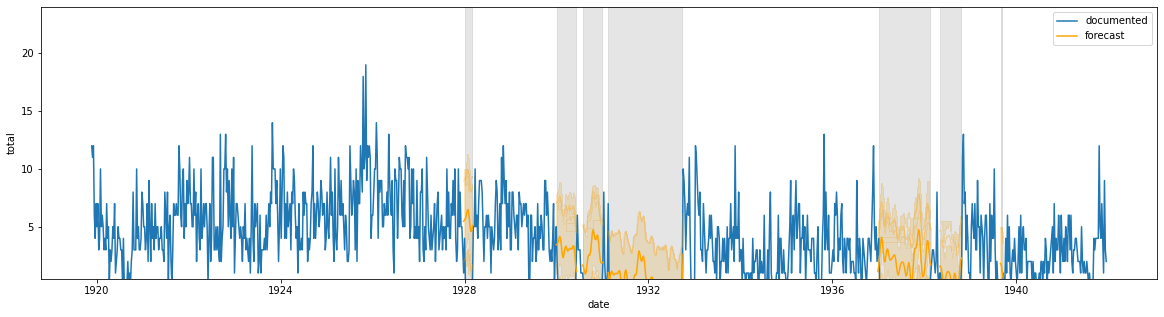

In [ ]:
plot_newsubs_weekly_forecast(newsub_weekly_forecasts)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:47: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:47: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:47: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:47: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:47: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:47: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


<Figure size 432x288 with 0 Axes>

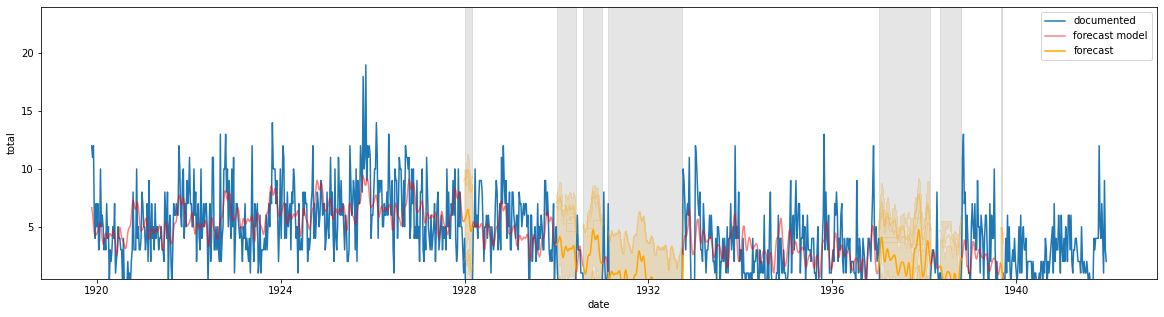

In [ ]:
plot_newsubs_weekly_forecast(newsub_weekly_forecasts, show_model=True)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:47: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:47: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:47: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:47: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:47: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:47: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


<Figure size 432x288 with 0 Axes>

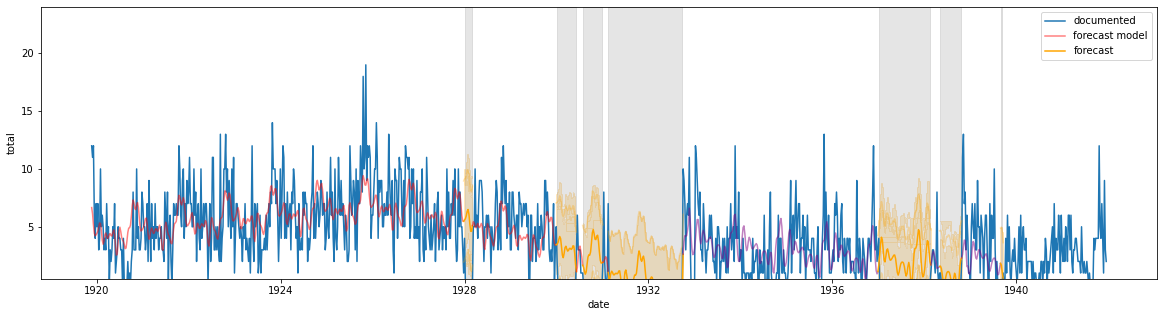

In [ ]:
plot_newsubs_weekly_forecast(newsub_weekly_forecasts, show_model=True, separate_model_decades=True)

### what if we fit prophet on all weeks?

In [ ]:
# what if we just train prophet on all the data?

from prophet import Prophet

post1932 = pd.to_datetime(date(1932, 9, 27))

newsub_m = Prophet(weekly_seasonality=True)
# rename monthly count columns for prophet and fit the data
newsub_m.fit(newmember_subscriptions_by_week.rename(columns={'date': 'ds', 'total': 'y'}))

# show some number of months before/after the gap and forecast
oneweek = timedelta(days=7)

# lists to aggregate forecasts and models
all_newsub_weekly_forecasts_dfs = []

# there's a significant difference between 1920s and 1930s data,
# and there's a big gap in 1931-1932
# for gaps after 1936, only include counts after the 1932 gap
#   February 16 1931 to September 26 1932 (588 days)
#   December 31 1936 to February 17 1938 (413 days)

post1932 = pd.to_datetime(date(1932, 9, 27))

for i, gap in enumerate(logbook_gaps):
  gap_start = gap['start']
  gap_end = gap['end']
  print('forecasting %s' % gap)

  weekly_m = Prophet()
  gap_start = gap['start']
  gap_end = gap['end']
  print('forecasting %s' % gap)

  # preceding_data = logbooks_weekly_count[logbooks_weekly_count.logbook_date < gap_start]
  preceding_data = newmember_subscriptions_by_week[newmember_subscriptions_by_week.date < gap_start]

  # for late gaps, only include counts after september 1932
  if gap_start.year >= 1936:
    preceding_data = preceding_data[preceding_data.date >= post1932 ]

  # drop any zeroes, so prophet doesn't fit to missing data
  preceding_data = preceding_data[preceding_data.total.gt(0)]

  # rename monthly count columns for prophet and fit thed ata
  weekly_m.fit(preceding_data.rename(columns={'date': 'ds', 'total': 'y'}))


  # make a future dataframe to cover the gap 
  # (need at least 1 extra; may want to add more while testing)
  forecast_for = math.ceil(gap['days']/ 7) + 7
  # forecast_for = float(gap['days'])/7.0 + 7
  print('gap is %s days, forecast for %d weeks' % (gap['days'], forecast_for))

  # use mini prophet to make the future relative to our gap
  newsub_weeks_future = weekly_m.make_future_dataframe(periods=forecast_for, freq='W')

  # newsub_weeks_future = newsub_m.make_future_dataframe(periods=forecast_for, freq='W')
  print(newsub_weeks_future.tail())
  newsub_weeks_fcst = newsub_m.predict(newsub_weeks_future)

  # plot the forecast around our gap
  forecast_near_gap = newsub_weeks_fcst[(newsub_weeks_fcst.ds > (gap_start - oneweek)) & (newsub_weeks_fcst.ds < (gap_end + oneweek))]
  display(forecast_near_gap.head())
  # all_gap_forecasts_dfs.append(forecast_near_gap)

  newsub_weekly_count_near_gap = newmember_subscriptions_by_week[(newmember_subscriptions_by_week.date > (gap_start - oneweek)) & (newmember_subscriptions_by_week.date < (gap_end + oneweek))]

  forecast_near_gap = newsub_weeks_fcst[(newsub_weeks_fcst.ds > (gap_start - oneweek)) & (newsub_weeks_fcst.ds < (gap_end + oneweek))]

  all_newsub_weekly_forecasts_dfs.append(newsub_weeks_fcst.copy())


all_newsub_weekly_forecasts_dfs
  

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


forecasting {'start': Timestamp('1928-01-01 00:00:00'), 'end': Timestamp('1928-02-29 00:00:00'), 'days': 59}
forecasting {'start': Timestamp('1928-01-01 00:00:00'), 'end': Timestamp('1928-02-29 00:00:00'), 'days': 59}
gap is 59 days, forecast for 16 weeks
            ds
423 1928-03-18
424 1928-03-25
425 1928-04-01
426 1928-04-08
427 1928-04-15


ds      trend  ...  multiplicative_terms_upper      yhat
412 1928-01-01  10.424578  ...                         0.0  4.705949
413 1928-01-08  10.407496  ...                         0.0  5.064248
414 1928-01-15  10.390414  ...                         0.0  5.487499
415 1928-01-22  10.373331  ...                         0.0  5.789843
416 1928-01-29  10.356249  ...                         0.0  5.768877

[5 rows x 19 columns]

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


forecasting {'start': Timestamp('1930-01-03 00:00:00'), 'end': Timestamp('1930-06-01 00:00:00'), 'days': 149}
forecasting {'start': Timestamp('1930-01-03 00:00:00'), 'end': Timestamp('1930-06-01 00:00:00'), 'days': 149}
gap is 149 days, forecast for 29 weeks
            ds
529 1930-06-22
530 1930-06-29
531 1930-07-06
532 1930-07-13
533 1930-07-20


ds     trend  ...  multiplicative_terms_upper      yhat
504 1929-12-29  8.648005  ...                         0.0  2.836372
505 1930-01-05  8.630923  ...                         0.0  3.138710
506 1930-01-12  8.613841  ...                         0.0  3.556365
507 1930-01-19  8.596758  ...                         0.0  3.927112
508 1930-01-26  8.579676  ...                         0.0  4.039054

[5 rows x 19 columns]

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


forecasting {'start': Timestamp('1930-08-01 00:00:00'), 'end': Timestamp('1930-12-31 00:00:00'), 'days': 152}
forecasting {'start': Timestamp('1930-08-01 00:00:00'), 'end': Timestamp('1930-12-31 00:00:00'), 'days': 152}
gap is 152 days, forecast for 29 weeks
            ds
538 1931-01-18
539 1931-01-25
540 1931-02-01
541 1931-02-08
542 1931-02-15


ds     trend  ...  multiplicative_terms_upper      yhat
513 1930-07-27  8.148928  ...                         0.0  1.832720
514 1930-08-03  8.134525  ...                         0.0  1.560056
515 1930-08-10  8.120122  ...                         0.0  1.359927
516 1930-08-17  8.105718  ...                         0.0  1.351215
517 1930-08-24  8.091315  ...                         0.0  1.590149

[5 rows x 19 columns]

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


forecasting {'start': Timestamp('1931-02-17 00:00:00'), 'end': Timestamp('1932-09-25 00:00:00'), 'days': 586}
forecasting {'start': Timestamp('1931-02-17 00:00:00'), 'end': Timestamp('1932-09-25 00:00:00'), 'days': 586}
gap is 586 days, forecast for 91 weeks
            ds
605 1932-10-16
606 1932-10-23
607 1932-10-30
608 1932-11-06
609 1932-11-13


ds     trend  ...  multiplicative_terms_upper      yhat
518 1931-02-15  7.731233  ...                         0.0  2.107496
519 1931-02-22  7.716829  ...                         0.0  1.996951
520 1931-03-01  7.702426  ...                         0.0  2.206554
521 1931-03-08  7.688023  ...                         0.0  2.434979
522 1931-03-15  7.681489  ...                         0.0  2.423647

[5 rows x 19 columns]

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


forecasting {'start': Timestamp('1937-01-01 00:00:00'), 'end': Timestamp('1938-02-16 00:00:00'), 'days': 411}
forecasting {'start': Timestamp('1937-01-01 00:00:00'), 'end': Timestamp('1938-02-16 00:00:00'), 'days': 411}
gap is 411 days, forecast for 66 weeks
            ds
248 1938-03-06
249 1938-03-13
250 1938-03-20
251 1938-03-27
252 1938-04-03


ds     trend  ...  multiplicative_terms_upper      yhat
186 1936-12-27  7.663722  ...                         0.0  1.804704
187 1937-01-03  7.664558  ...                         0.0  2.076715
188 1937-01-10  7.665394  ...                         0.0  2.496056
189 1937-01-17  7.666230  ...                         0.0  2.915565
190 1937-01-24  7.667066  ...                         0.0  3.128630

[5 rows x 19 columns]

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


forecasting {'start': Timestamp('1938-05-06 00:00:00'), 'end': Timestamp('1938-10-20 00:00:00'), 'days': 167}
forecasting {'start': Timestamp('1938-05-06 00:00:00'), 'end': Timestamp('1938-10-20 00:00:00'), 'days': 167}
gap is 167 days, forecast for 31 weeks
            ds
224 1938-11-06
225 1938-11-13
226 1938-11-20
227 1938-11-27
228 1938-12-04


ds     trend  ...  multiplicative_terms_upper      yhat
197 1938-05-01  7.722250  ...                         0.0  2.222330
198 1938-05-08  7.723086  ...                         0.0  2.242553
199 1938-05-15  7.723922  ...                         0.0  2.182138
200 1938-05-22  7.724758  ...                         0.0  1.868439
201 1938-05-29  7.725594  ...                         0.0  1.345295

[5 rows x 19 columns]

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


forecasting {'start': Timestamp('1939-08-29 00:00:00'), 'end': Timestamp('1939-09-12 00:00:00'), 'days': 14}
forecasting {'start': Timestamp('1939-08-29 00:00:00'), 'end': Timestamp('1939-09-12 00:00:00'), 'days': 14}
gap is 14 days, forecast for 9 weeks
            ds
239 1939-09-03
240 1939-09-10
241 1939-09-17
242 1939-09-24
243 1939-10-01


ds     trend  ...  multiplicative_terms_upper      yhat
238 1939-08-27  7.779942  ...                         0.0  1.418273
239 1939-09-03  7.780778  ...                         0.0  1.724889
240 1939-09-10  7.781614  ...                         0.0  1.806261
241 1939-09-17  7.782450  ...                         0.0  1.742952

[4 rows x 19 columns]

[            ds      trend  ...  multiplicative_terms_upper      yhat
 0   1919-11-23  10.176542  ...                         0.0  6.654890
 1   1919-11-30  10.182642  ...                         0.0  6.153220
 2   1919-12-07  10.188742  ...                         0.0  5.379244
 3   1919-12-14  10.194842  ...                         0.0  4.686471
 4   1919-12-21  10.200942  ...                         0.0  4.334710
 ..         ...        ...  ...                         ...       ...
 423 1928-03-18  10.236672  ...                         0.0  4.872950
 424 1928-03-25  10.219589  ...                         0.0  4.618136
 425 1928-04-01  10.202507  ...                         0.0  4.509289
 426 1928-04-08  10.185424  ...                         0.0  4.580141
 427 1928-04-15  10.168342  ...                         0.0  4.673676
 
 [428 rows x 19 columns],
             ds      trend  ...  multiplicative_terms_upper      yhat
 0   1919-11-23  10.176542  ...                         0.0  6

In [ ]:
newsub_weekly_forecasts_df = pd.concat(all_newsub_weekly_forecasts_dfs)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:47: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:47: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:47: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:47: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:47: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:47: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


<Figure size 432x288 with 0 Axes>

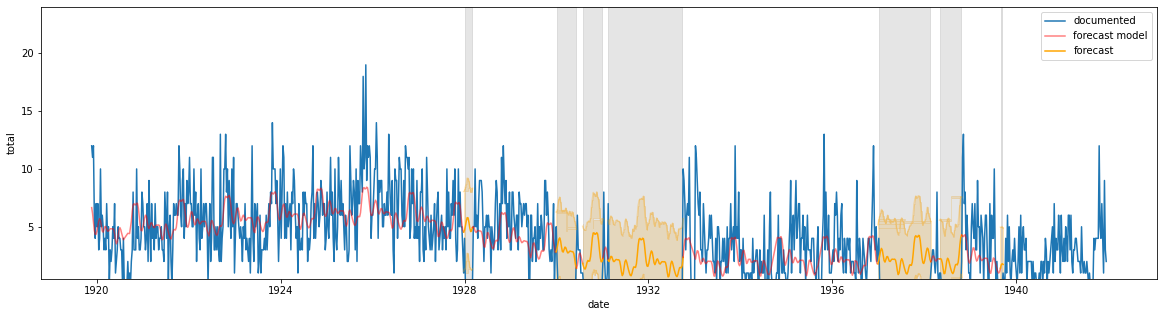

In [ ]:
plot_newsubs_weekly_forecast(newsub_weekly_forecasts_df, show_model=True) #, separate_model_decades=True)

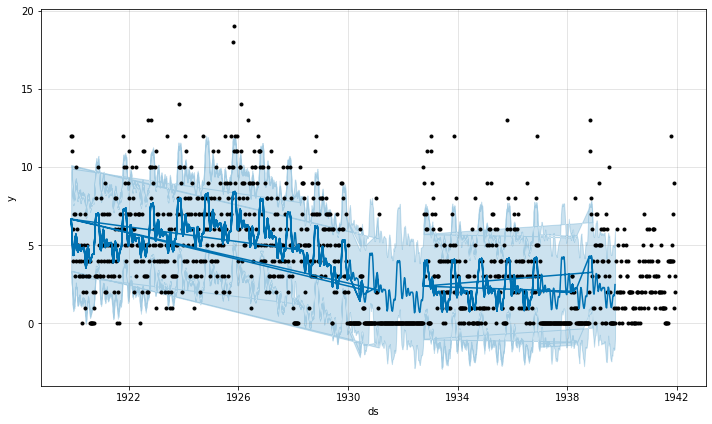

In [ ]:
fig1 = newsub_m.plot(newsub_weekly_forecasts_df)

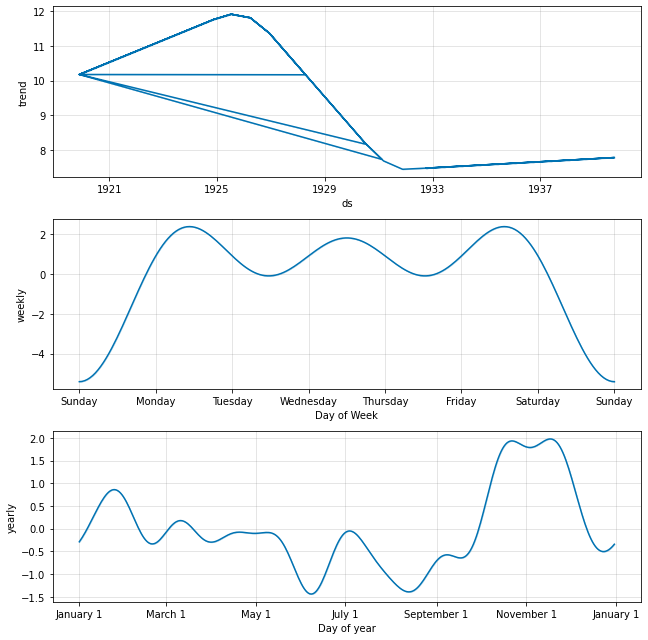

In [ ]:
fig2 = newsub_m.plot_components(newsub_weekly_forecasts_df)

In [ ]:
# plot new subscriptions logbooks with gaps
from altair import datum

newsubs_forecast_base = alt.Chart(newsub_weekly_forecasts).encode(
    alt.X('ds:T', axis=alt.Axis(title='date'))
).properties(
    width=1200,
    height=275
)

newsubs_forecast_line = newsubs_forecast_base.mark_line(color="orange").encode(
    alt.Y('yhat',
          axis=alt.Axis(title='new subscriptions per week'), scale=alt.Scale(domain=[0, 20])),
)
# .transform_filter(
    # alt.FieldLTPredicate(field='ds', lt=date(1919, 1,1))
# )

newsubs_area = newsubs_forecast_base.mark_area(opacity=0.3, color='orange').encode(
    alt.Y('yhat_upper',
          axis=alt.Axis(title=None), scale=alt.Scale(domain=[0, 20])),
    alt.Y2('yhat_lower')
)

# add newsubs last so it will be layered on top
newsubs_line + logbook_gaps_span + newsubs_area + newsubs_forecast_line

alt.LayerChart(...)

### forecast again, with growth and cap

the default forecast behavior is following a downward trend in the existing data leading into our later gaps, but based on the data afterwards that doesn't look right. 




In [ ]:
# when is the largest week? 
growth_cap = newmember_subscriptions_by_week.total.max()
newmember_subscriptions_by_week[newmember_subscriptions_by_week.total == growth_cap]

date  total
311 1925-11-08     19

In [ ]:
from datetime import date, timedelta
import math

from prophet import Prophet

post1932 = pd.to_datetime(date(1932, 9, 27))


def growth_forecast_missing_newsubs():
  # show some number of months before/after the gap and forecast
  oneweek = timedelta(days=7)
  sixweeks = timedelta(days=7*6)

  # lists to aggregate forecasts and models
  all_newsub_weekly_forecasts_dfs = []

  # there's a significant difference between 1920s and 1930s data,
  # and there's a big gap in 1931-1932
  # for gaps after 1936, only include counts after the 1932 gap
  #   February 16 1931 to September 26 1932 (588 days)
  #   December 31 1936 to February 17 1938 (413 days)

  post1932 = pd.to_datetime(date(1932, 9, 27))

  # use largest week across all data as our growth cap
  growth_cap = newmember_subscriptions_by_week.total.max()
  print('max from all data is %s' % growth_cap)


  for i, gap in enumerate(logbook_gaps):
    weekly_m = Prophet(growth='logistic', weekly_seasonality=True)  # use logistic growth instead of linear
    gap_start = gap['start']
    gap_end = gap['end']
    print('forecasting %s' % gap)

    preceding_data = newmember_subscriptions_by_week[newmember_subscriptions_by_week.date < gap_start]

    # for late gaps, only include counts after september 1932
    if gap_start.year >= 1936:
      preceding_data = preceding_data[preceding_data.date >= post1932 ]

    # drop any zeroes, so prophet doesn't fit to missing data
    preceding_data = preceding_data[preceding_data.total.gt(0)]

    # rename monthly count columns for prophet and fit the data
    data_to_fit = preceding_data.rename(columns={'date': 'ds', 'total': 'y'})
    data_to_fit['floor'] = 0
    # (should this be max from current data or next? or both? or all?)
    data_to_fit['cap'] = growth_cap
    weekly_m.fit(data_to_fit)

    # make a future dataframe to cover the gap 
    # (need at least 1 extra; may want to add more while testing)
    forecast_for = math.ceil(gap['days']/ 7) + 7
    print('gap is %s days, forecast for %d weeks' % (gap['days'], forecast_for))
    newsub_weeks_future = weekly_m.make_future_dataframe(periods=forecast_for, freq='W')

    # post_gap_data = newmember_subscriptions_by_week[newmember_subscriptions_by_week.date > gap_end][newmember_subscriptions_by_week.date < (gap_end + sixweeks)]
    newsub_weeks_future['floor'] = 0
    newsub_weeks_future['cap'] = growth_cap
    newsub_weeks_fcst = weekly_m.predict(newsub_weeks_future)

    # plot the forecast around our gap
    forecast_near_gap = newsub_weeks_fcst[(newsub_weeks_fcst.ds > (gap_start - oneweek)) & (newsub_weeks_fcst.ds < (gap_end + oneweek))]
    display(forecast_near_gap.head())
    # all_gap_forecasts_dfs.append(forecast_near_gap)

    newsub_weekly_count_near_gap = newmember_subscriptions_by_week[(newmember_subscriptions_by_week.date > (gap_start - oneweek)) & (newmember_subscriptions_by_week.date < (gap_end + oneweek))]

    forecast_near_gap = newsub_weeks_fcst[(newsub_weeks_fcst.ds > (gap_start - oneweek)) & (newsub_weeks_fcst.ds < (gap_end + oneweek))]

    all_newsub_weekly_forecasts_dfs.append(newsub_weeks_fcst.copy())

  # combine all the forecasts into a single df
  newsub_weekly_forecasts_dfs = pd.concat(all_newsub_weekly_forecasts_dfs)
  # all_gap_forecasts = pd.concat(all_gap_forecasts_dfs)

  return newsub_weekly_forecasts_dfs


newsub_weekly_growth_forecasts = growth_forecast_missing_newsubs()
newsub_weekly_growth_forecasts

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


max from all data is 19
forecasting {'start': Timestamp('1928-01-01 00:00:00'), 'end': Timestamp('1928-02-29 00:00:00'), 'days': 59}
gap is 59 days, forecast for 16 weeks


ds     trend  ...  multiplicative_terms_upper      yhat
412 1928-01-01  0.002428  ...                         0.0  5.830816
413 1928-01-08  0.002409  ...                         0.0  6.120623
414 1928-01-15  0.002390  ...                         0.0  6.606938
415 1928-01-22  0.002371  ...                         0.0  7.195454
416 1928-01-29  0.002353  ...                         0.0  7.414366

[5 rows x 21 columns]

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


forecasting {'start': Timestamp('1930-01-03 00:00:00'), 'end': Timestamp('1930-06-01 00:00:00'), 'days': 149}
gap is 149 days, forecast for 29 weeks


ds     trend  ...  multiplicative_terms_upper      yhat
504 1929-12-29  9.943319  ...                         0.0  5.819951
505 1930-01-05  9.944565  ...                         0.0  6.160101
506 1930-01-12  9.945812  ...                         0.0  6.758227
507 1930-01-19  9.947058  ...                         0.0  7.440121
508 1930-01-26  9.948304  ...                         0.0  7.778456

[5 rows x 21 columns]

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


forecasting {'start': Timestamp('1930-08-01 00:00:00'), 'end': Timestamp('1930-12-31 00:00:00'), 'days': 152}
gap is 152 days, forecast for 29 weeks


ds     trend  ...  multiplicative_terms_upper      yhat
513 1930-07-27  0.007332  ...                         0.0  4.826227
514 1930-08-03  0.007288  ...                         0.0  4.871885
515 1930-08-10  0.007244  ...                         0.0  4.788594
516 1930-08-17  0.007200  ...                         0.0  4.695630
517 1930-08-24  0.007157  ...                         0.0  4.888529

[5 rows x 21 columns]

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


forecasting {'start': Timestamp('1931-02-17 00:00:00'), 'end': Timestamp('1932-09-25 00:00:00'), 'days': 586}
gap is 586 days, forecast for 91 weeks


ds     trend  ...  multiplicative_terms_upper      yhat
518 1931-02-15  9.602312  ...                         0.0  5.482371
519 1931-02-22  9.602672  ...                         0.0  5.275108
520 1931-03-01  9.603032  ...                         0.0  5.647469
521 1931-03-08  9.603391  ...                         0.0  6.020484
522 1931-03-15  9.603751  ...                         0.0  5.946049

[5 rows x 21 columns]

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


forecasting {'start': Timestamp('1937-01-01 00:00:00'), 'end': Timestamp('1938-02-16 00:00:00'), 'days': 411}
gap is 411 days, forecast for 66 weeks


ds     trend  ...  multiplicative_terms_upper      yhat
186 1936-12-27  6.605094  ...                         0.0  2.311513
187 1937-01-03  6.598154  ...                         0.0  2.961683
188 1937-01-10  6.591218  ...                         0.0  3.820930
189 1937-01-17  6.584286  ...                         0.0  4.707716
190 1937-01-24  6.577356  ...                         0.0  5.160298

[5 rows x 21 columns]

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


forecasting {'start': Timestamp('1938-05-06 00:00:00'), 'end': Timestamp('1938-10-20 00:00:00'), 'days': 167}
gap is 167 days, forecast for 31 weeks


ds     trend  ...  multiplicative_terms_upper      yhat
197 1938-05-01  0.111489  ...                         0.0  2.728618
198 1938-05-08  0.110358  ...                         0.0  3.041560
199 1938-05-15  0.109239  ...                         0.0  3.220624
200 1938-05-22  0.108131  ...                         0.0  2.965704
201 1938-05-29  0.107033  ...                         0.0  2.305107

[5 rows x 21 columns]

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


forecasting {'start': Timestamp('1939-08-29 00:00:00'), 'end': Timestamp('1939-09-12 00:00:00'), 'days': 14}
gap is 14 days, forecast for 9 weeks


ds     trend  ...  multiplicative_terms_upper      yhat
238 1939-08-27  0.181809  ...                         0.0  3.397243
239 1939-09-03  0.180779  ...                         0.0  2.691236
240 1939-09-10  0.179754  ...                         0.0  1.806824
241 1939-09-17  0.178736  ...                         0.0  1.692956

[4 rows x 21 columns]

ds     trend  ...  multiplicative_terms_upper      yhat
0   1919-11-23  0.069339  ...                         0.0  8.386637
1   1919-11-30  0.068793  ...                         0.0  7.662353
2   1919-12-07  0.068252  ...                         0.0  6.566244
3   1919-12-14  0.067715  ...                         0.0  5.787500
4   1919-12-21  0.067181  ...                         0.0  5.600560
..         ...       ...  ...                         ...       ...
239 1939-09-03  0.180779  ...                         0.0  2.691236
240 1939-09-10  0.179754  ...                         0.0  1.806824
241 1939-09-17  0.178736  ...                         0.0  1.692956
242 1939-09-24  0.177723  ...                         0.0  2.543510
243 1939-10-01  0.176715  ...                         0.0  3.641606

[2841 rows x 21 columns]

#### plot the forecasts

<Figure size 432x288 with 0 Axes>

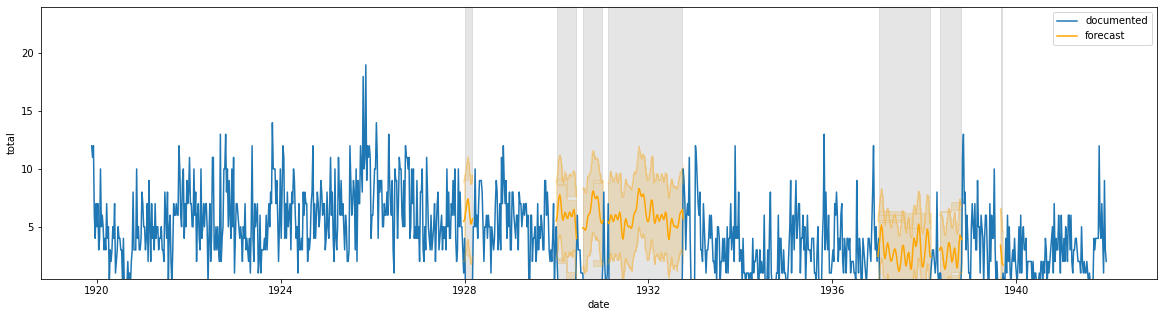

In [ ]:
plot_newsubs_weekly_forecast(newsub_weekly_growth_forecasts)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:47: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:47: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:47: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:47: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:47: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:47: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


<Figure size 432x288 with 0 Axes>

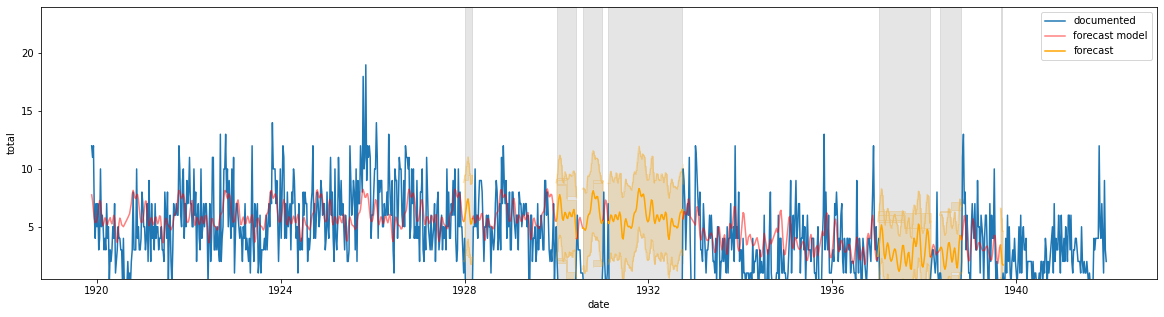

In [ ]:
plot_newsubs_weekly_forecast(newsub_weekly_growth_forecasts, show_model=True)

### fit on all weeks, logistic growth

In [ ]:
lognewsub_m = Prophet(weekly_seasonality=True, growth='logistic')
# use largest week across all data as our growth cap
growth_cap = newmember_subscriptions_by_week.total.max()

newmember_weekly_subs = newmember_subscriptions_by_week.rename(columns={'date': 'ds', 'total': 'y'})
newmember_weekly_subs['floor'] = 0
newmember_weekly_subs['cap'] = growth_cap
# rename monthly count columns for prophet and fit the data
lognewsub_m.fit(newmember_weekly_subs)

# lognewsub_weeks_fcst

post1932 = pd.to_datetime(date(1932, 9, 27))

# show some number of months before/after the gap and forecast
oneweek = timedelta(days=7)

# lists to aggregate forecasts and models
all_lognewsub_forecasts_dfs = []

# there's a significant difference between 1920s and 1930s data,
# and there's a big gap in 1931-1932
# for gaps after 1936, only include counts after the 1932 gap
#   February 16 1931 to September 26 1932 (588 days)
#   December 31 1936 to February 17 1938 (413 days)

post1932 = pd.to_datetime(date(1932, 9, 27))

for i, gap in enumerate(logbook_gaps):
  gap_start = gap['start']
  gap_end = gap['end']
  print('forecasting %s' % gap)

  weekly_m = Prophet()
  gap_start = gap['start']
  gap_end = gap['end']
  print('forecasting %s' % gap)

  # preceding_data = logbooks_weekly_count[logbooks_weekly_count.logbook_date < gap_start]
  preceding_data = newmember_subscriptions_by_week[newmember_subscriptions_by_week.date < gap_start]

  # for late gaps, only include counts after september 1932
  if gap_start.year >= 1936:
    preceding_data = preceding_data[preceding_data.date >= post1932 ]

  # drop any zeroes, so prophet doesn't fit to missing data
  # FIXME: needed/wanted?
  preceding_data = preceding_data[preceding_data.total.gt(0)]

  preceding_data['floor'] = 0
  preceding_data['cap'] = growth_cap

  # rename monthly count columns for prophet and fit the data
  weekly_m.fit(preceding_data.rename(columns={'date': 'ds', 'total': 'y'}))

  # make a future dataframe to cover the gap 
  # (need at least 1 extra; may want to add more while testing)
  forecast_for = math.ceil(gap['days']/ 7) + 7
  # forecast_for = float(gap['days'])/7.0 + 7
  print('gap is %s days, forecast for %d weeks' % (gap['days'], forecast_for))

  # use mini prophet to make the future relative to our gap
  newsub_weeks_future = weekly_m.make_future_dataframe(periods=forecast_for, freq='W')

  # newsub_weeks_future = newsub_m.make_future_dataframe(periods=forecast_for, freq='W')
  newsub_weeks_future['floor'] = 0
  newsub_weeks_future['cap'] = growth_cap
  newsub_weeks_fcst = lognewsub_m.predict(newsub_weeks_future)

  # plot the forecast around our gap
  forecast_near_gap = newsub_weeks_fcst[(newsub_weeks_fcst.ds > (gap_start - oneweek)) & (newsub_weeks_fcst.ds < (gap_end + oneweek))]
  display(forecast_near_gap.head())
  # all_gap_forecasts_dfs.append(forecast_near_gap)

  newsub_weekly_count_near_gap = newmember_subscriptions_by_week[(newmember_subscriptions_by_week.date > (gap_start - oneweek)) & (newmember_subscriptions_by_week.date < (gap_end + oneweek))]

  forecast_near_gap = newsub_weeks_fcst[(newsub_weeks_fcst.ds > (gap_start - oneweek)) & (newsub_weeks_fcst.ds < (gap_end + oneweek))]

  all_lognewsub_forecasts_dfs.append(newsub_weeks_fcst.copy())


all_lognewsub_forecasts_dfs  


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


forecasting {'start': Timestamp('1928-01-01 00:00:00'), 'end': Timestamp('1928-02-29 00:00:00'), 'days': 59}
forecasting {'start': Timestamp('1928-01-01 00:00:00'), 'end': Timestamp('1928-02-29 00:00:00'), 'days': 59}
gap is 59 days, forecast for 16 weeks


ds     trend  ...  multiplicative_terms_upper      yhat
412 1928-01-01  2.773468  ...                         0.0  3.696493
413 1928-01-08  2.768381  ...                         0.0  4.065052
414 1928-01-15  2.763302  ...                         0.0  4.505912
415 1928-01-22  2.758231  ...                         0.0  4.827677
416 1928-01-29  2.753167  ...                         0.0  4.821810

[5 rows x 21 columns]

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


forecasting {'start': Timestamp('1930-01-03 00:00:00'), 'end': Timestamp('1930-06-01 00:00:00'), 'days': 149}
forecasting {'start': Timestamp('1930-01-03 00:00:00'), 'end': Timestamp('1930-06-01 00:00:00'), 'days': 149}
gap is 149 days, forecast for 29 weeks


ds     trend  ...  multiplicative_terms_upper      yhat
504 1929-12-29  2.284740  ...                         0.0  3.116981
505 1930-01-05  2.280424  ...                         0.0  3.427828
506 1930-01-12  2.276114  ...                         0.0  3.861556
507 1930-01-19  2.271812  ...                         0.0  4.252727
508 1930-01-26  2.267516  ...                         0.0  4.382453

[5 rows x 21 columns]

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


forecasting {'start': Timestamp('1930-08-01 00:00:00'), 'end': Timestamp('1930-12-31 00:00:00'), 'days': 152}
forecasting {'start': Timestamp('1930-08-01 00:00:00'), 'end': Timestamp('1930-12-31 00:00:00'), 'days': 152}
gap is 152 days, forecast for 29 weeks


ds     trend  ...  multiplicative_terms_upper      yhat
513 1930-07-27  2.158281  ...                         0.0  2.558296
514 1930-08-03  2.154173  ...                         0.0  2.295640
515 1930-08-10  2.150071  ...                         0.0  2.108280
516 1930-08-17  2.145977  ...                         0.0  2.114815
517 1930-08-24  2.141889  ...                         0.0  2.367585

[5 rows x 21 columns]

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


forecasting {'start': Timestamp('1931-02-17 00:00:00'), 'end': Timestamp('1932-09-25 00:00:00'), 'days': 586}
forecasting {'start': Timestamp('1931-02-17 00:00:00'), 'end': Timestamp('1932-09-25 00:00:00'), 'days': 586}
gap is 586 days, forecast for 91 weeks


ds     trend  ...  multiplicative_terms_upper      yhat
518 1931-02-15  2.041882  ...                         0.0  3.074612
519 1931-02-22  2.037968  ...                         0.0  2.979873
520 1931-03-01  2.034061  ...                         0.0  3.204689
521 1931-03-08  2.030161  ...                         0.0  3.445030
522 1931-03-15  2.026267  ...                         0.0  3.436431

[5 rows x 21 columns]

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


forecasting {'start': Timestamp('1937-01-01 00:00:00'), 'end': Timestamp('1938-02-16 00:00:00'), 'days': 411}
forecasting {'start': Timestamp('1937-01-01 00:00:00'), 'end': Timestamp('1938-02-16 00:00:00'), 'days': 411}
gap is 411 days, forecast for 66 weeks


ds     trend  ...  multiplicative_terms_upper      yhat
186 1936-12-27  1.115594  ...                         0.0  1.902231
187 1937-01-03  1.113340  ...                         0.0  2.165537
188 1937-01-10  1.111089  ...                         0.0  2.583178
189 1937-01-17  1.108843  ...                         0.0  3.006827
190 1937-01-24  1.106601  ...                         0.0  3.222983

[5 rows x 21 columns]

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


forecasting {'start': Timestamp('1938-05-06 00:00:00'), 'end': Timestamp('1938-10-20 00:00:00'), 'days': 167}
forecasting {'start': Timestamp('1938-05-06 00:00:00'), 'end': Timestamp('1938-10-20 00:00:00'), 'days': 167}
gap is 167 days, forecast for 31 weeks


ds     trend  ...  multiplicative_terms_upper      yhat
197 1938-05-01  0.967709  ...                         0.0  2.154107
198 1938-05-08  0.965737  ...                         0.0  2.175901
199 1938-05-15  0.963768  ...                         0.0  2.114706
200 1938-05-22  0.961804  ...                         0.0  1.798417
201 1938-05-29  0.959843  ...                         0.0  1.273887

[5 rows x 21 columns]

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


forecasting {'start': Timestamp('1939-08-29 00:00:00'), 'end': Timestamp('1939-09-12 00:00:00'), 'days': 14}
forecasting {'start': Timestamp('1939-08-29 00:00:00'), 'end': Timestamp('1939-09-12 00:00:00'), 'days': 14}
gap is 14 days, forecast for 9 weeks


ds     trend  ...  multiplicative_terms_upper      yhat
238 1939-08-27  0.840232  ...                         0.0  1.205755
239 1939-09-03  0.838508  ...                         0.0  1.508743
240 1939-09-10  0.836787  ...                         0.0  1.587595
241 1939-09-17  0.835069  ...                         0.0  1.526133

[4 rows x 21 columns]

[            ds     trend  ...  multiplicative_terms_upper      yhat
 0   1919-11-23  5.662880  ...                         0.0  8.824026
 1   1919-11-30  5.654267  ...                         0.0  8.282777
 2   1919-12-07  5.645663  ...                         0.0  7.486393
 3   1919-12-14  5.637066  ...                         0.0  6.780715
 4   1919-12-21  5.628476  ...                         0.0  6.413771
 ..         ...       ...  ...                         ...       ...
 423 1928-03-18  2.717938  ...                         0.0  4.023081
 424 1928-03-25  2.712935  ...                         0.0  3.784369
 425 1928-04-01  2.707941  ...                         0.0  3.692675
 426 1928-04-08  2.702954  ...                         0.0  3.778380
 427 1928-04-15  2.697975  ...                         0.0  3.884271
 
 [428 rows x 21 columns],
             ds     trend  ...  multiplicative_terms_upper      yhat
 0   1919-11-23  5.662880  ...                         0.0  8.824026
 1   1

In [ ]:
lognewsub_weeks_fcst = pd.concat(all_lognewsub_forecasts_dfs)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:47: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:47: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:47: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:47: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:47: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:47: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


<Figure size 432x288 with 0 Axes>

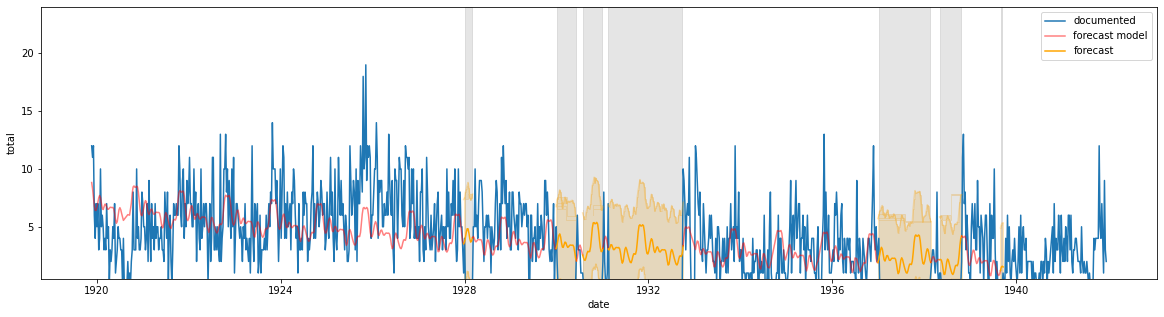

In [ ]:
plot_newsubs_weekly_forecast(lognewsub_weeks_fcst, show_model=True)

### aggregate forecast values

In [ ]:
%%capture
!pip install DateTimeRange

In [ ]:
from datetimerange import DateTimeRange


onemonth = timedelta(days=31)
fivedays = timedelta(days=5)
oneday = timedelta(days=5)
oneweek = timedelta(days=7)

# newsub_member_total = len(subscription_first_events.member_id.unique())
# member_total = len(events_df.member_id.unique())

# allow overrides for aggregrating uniq name estimates
def aggregrate_missing_newsub_estimates(forecast_df, newmember_subscriptions_by_week=newmember_subscriptions_by_week, newsub_member_total=None, member_total=None):

  newsub_weekly_missing = 0
  newsub_weekly_missing_upper = 0
  newsub_weekly_missing_lower = 0

  if newsub_member_total is None:
    newsub_member_total = len(subscription_first_events.member_id.unique())
  if member_total is None:
    member_total = len(events_df.member_id.unique())


  newsub_weekly_estimates = []

  for i, gap in enumerate(logbook_gaps): 
    gap_start = gap['start']
    gap_end = gap['end']
    # print(gap_start, gap_end)
    # print('gap range ')
    gap_range = DateTimeRange(gap_start, gap_end)
    # print(gap_range)

    # get documented counts for this time period
    gap_counts = newmember_subscriptions_by_week[(newmember_subscriptions_by_week.date >= gap_start) & (newmember_subscriptions_by_week.date <= gap_end + oneweek)]
    # now get the forecast for the same weeks
    
    # weekly_forecast = newsub_weekly_forecasts_df[(newsub_weekly_forecasts_df.ds >= gap_start) & (newsub_weekly_forecasts_df.ds <= gap_end + oneweek)]

    weekly_forecast = forecast_df[(forecast_df.ds >= gap_start) & (forecast_df.ds <= gap_end + oneweek)]
    # print(weekly_forecast[['ds', 'yhat', 'yhat_upper', 'yhat_lower']].head())

    for week in gap_counts.itertuples():
      week_start = week.date 

      # do logbook weeks and forecast weeks match?
      # missing estimate is the forecast value minus any actual recorded count for this day
      documented_week = newmember_subscriptions_by_week[newmember_subscriptions_by_week.date == week.date]  #.iloc[0]
      # seems possible there's no documented week
      if documented_week.shape[0]:
        documented_week = documented_week.iloc[0]
      else: 
        documented_week = None

      # check if the padding put us past the end of the current gap
      if week_start > gap_end:
        continue

      # get the end of the same month (first of the next month minus one day)
      week_end = week_start + oneweek
      # how many days from this month overlap with our gap?
      gap_intersection = gap_range.intersection(DateTimeRange(week_start, week_end))
      overlap_days = gap_intersection.timedelta.days
      if overlap_days != 7:
        print('gap overlap for %s is %d days' % (week_end, overlap_days))
      # what is our threshold for using the forecast value instead of recorded? 
      # let's try 3 days
      if overlap_days > 3:
        week_total = 0
        if not documented_week.empty:
          week_total = week.total

        # get the forecast value for this week
        week_forecast = weekly_forecast[(weekly_forecast.ds >= week_start) & (weekly_forecast.ds <= week_end)].iloc[0]
        # missing estimate is the forecast value minus any actual recorded count for this month
        newsub_weekly_missing += max(0, (max(0, week_forecast.yhat) - week_total))
        newsub_weekly_missing_upper += (week_forecast.yhat_upper - week_total)
        # cap lower estimate at zero
        newsub_weekly_missing_lower += max(0, (max(0, week_forecast.yhat_lower) - week_total))

        # aggregate forecast values so we can output as csv for reference
        newsub_weekly_estimates.append({
            'date': week.date,
            'documented_total': week_total,
            'gap_days': overlap_days,
            'forecast': week_forecast.yhat,
            'forecast_upper': week_forecast.yhat_upper,
            'forecast_lower': week_forecast.yhat_lower,
            'forecast_range': week_forecast.yhat_upper - week_forecast.yhat_lower,
        })

        newsub_estimates_df = pd.DataFrame(newsub_weekly_estimates)
        newsub_estimates_df.to_csv('newsub_weekly_forecast.csv', index=False)

  print('''\n\nmissing estimates:
    %s
    upper: %s
    lower: %s''' % (newsub_weekly_missing, newsub_weekly_missing_upper, newsub_weekly_missing_lower))
  
  estimated_total = newsub_member_total + newsub_weekly_missing
  estimated_total_upper = newsub_member_total + newsub_weekly_missing_upper
  estimated_total_lower = newsub_member_total + newsub_weekly_missing_lower

  est_percent = (member_total / estimated_total ) * 100
  est_percent_upper = (member_total / estimated_total_upper ) * 100
  est_percent_lower = (member_total / estimated_total_lower ) * 100

  # summarize the result
  print('''
  total unique members: %d
  total members from first subscriptions: %d
  estimated missing subscriptions: %.2f (upper %.2f, lower %.2f)
  estimated total subscriptions from logbooks: %.2f (upper %.2f, lower %.2f)
  total missing: %d (upper %d, lower %d)
  estimated percent: %.2f (upper %.2f, lower %.2f)
  ''' % (member_total, newsub_member_total, 
         # estimated missing
          newsub_weekly_missing, newsub_weekly_missing_upper, newsub_weekly_missing_lower,
         # estimated total
          estimated_total, estimated_total_upper, estimated_total_lower, 
         # total missing
          max(0, estimated_total - member_total),
            estimated_total_upper - member_total,
          max(0, estimated_total_lower - member_total),
          est_percent, est_percent_upper, est_percent_lower
          ))
  
  # return (newsub_weekly_missing, newsub_weekly_missing_upper, newsub_weekly_missing_lower)
  
# newsub_missing, newsub_missing_upper, newsub_missing_lower = aggregrate_missing_newsub_estimates()

### summarize

In [ ]:
# initial forecast, calculated the same way as membership activity
aggregrate_missing_newsub_estimates(newsub_weekly_forecasts)

gap overlap for 1928-03-04 00:00:00 is 3 days
gap overlap for 1930-06-08 00:00:00 is 0 days
gap overlap for 1931-01-04 00:00:00 is 3 days
gap overlap for 1932-10-02 00:00:00 is 0 days
gap overlap for 1938-02-20 00:00:00 is 3 days
gap overlap for 1938-10-23 00:00:00 is 4 days
gap overlap for 1939-09-17 00:00:00 is 2 days


missing estimates:
    459.35352816239197
    upper: 1136.2228264121973
    lower: 93.23247568325611

  total unique members: 5139
  total members from first subscriptions: 4320
  estimated missing subscriptions: 459.35 (upper 1136.22, lower 93.23)
  estimated total subscriptions from logbooks: 4779.35 (upper 5456.22, lower 4413.23)
  total missing: 0 (upper 317, lower 0)
  estimated percent: 107.53 (upper 94.19, lower 116.45)
  


In [ ]:
# second forecast, fitting prophet on all data 
# - this result seems better than the first linear model
aggregrate_missing_newsub_estimates(newsub_weekly_forecasts_df)


gap overlap for 1928-03-04 00:00:00 is 3 days
gap overlap for 1930-06-08 00:00:00 is 0 days
gap overlap for 1931-01-04 00:00:00 is 3 days
gap overlap for 1932-10-02 00:00:00 is 0 days
gap overlap for 1938-02-20 00:00:00 is 3 days
gap overlap for 1938-10-23 00:00:00 is 4 days
gap overlap for 1939-09-17 00:00:00 is 2 days


missing estimates:
    498.92351611172603
    upper: 1228.7164825414452
    lower: 32.793905254324194

  total unique members: 5139
  total members from first subscriptions: 4320
  estimated missing subscriptions: 498.92 (upper 1228.72, lower 32.79)
  estimated total subscriptions from logbooks: 4818.92 (upper 5548.72, lower 4352.79)
  total missing: 0 (upper 409, lower 0)
  estimated percent: 106.64 (upper 92.62, lower 118.06)
  


In [ ]:
# third forecast, with logistic growth and cap
aggregrate_missing_newsub_estimates(newsub_weekly_growth_forecasts)

gap overlap for 1928-03-04 00:00:00 is 3 days
gap overlap for 1930-06-08 00:00:00 is 0 days
gap overlap for 1931-01-04 00:00:00 is 3 days
gap overlap for 1932-10-02 00:00:00 is 0 days
gap overlap for 1938-02-20 00:00:00 is 3 days
gap overlap for 1938-10-23 00:00:00 is 4 days
gap overlap for 1939-09-17 00:00:00 is 2 days


missing estimates:
    1030.2251804119082
    upper: 1733.1889826344106
    lower: 371.2593405001614

  total unique members: 5139
  total members from first subscriptions: 4320
  estimated missing subscriptions: 1030.23 (upper 1733.19, lower 371.26)
  estimated total subscriptions from logbooks: 5350.23 (upper 6053.19, lower 4691.26)
  total missing: 211 (upper 914, lower 0)
  estimated percent: 96.05 (upper 84.90, lower 109.54)
  


## new members by first subscription, aggregated by unique name

In [ ]:
member_events.head()

event_type      member_id       date                   source_type
671    Subscription          cahun 1919-11-17  Lending Library Card;Logbook
29914  Subscription       worthing 1919-11-17                       Logbook
29915  Subscription  flot-marcelle 1919-11-17                       Logbook
672    Subscription        regnier 1919-11-18  Logbook;Lending Library Card
676    Subscription         ulmann 1919-11-18  Logbook;Lending Library Card

In [ ]:
# member events doesn't include names, so join to get it back in

events_df[['member_id', 'member_names', 'member_sort_names']]

member_id         member_names     member_sort_names
0       linossier-raymonde   Raymonde Linossier   Linossier, Raymonde
1                  garreta          Mme Garreta          Garreta, Mme
2                     rhys             Mr. Rhys             Rhys, Mr.
3                    walsh         Ernest Walsh         Walsh, Ernest
4                lincoln-1          Mr. Lincoln          Lincoln, Mr.
...                    ...                  ...                   ...
35518        gutmann-henri        Henri Gutmann        Gutmann, Henri
35519  bernheim-antoinette  Antoinette Bernheim  Bernheim, Antoinette
35520           baldwin-mr          Mr. Baldwin          Baldwin, Mr.
35521  bernheim-antoinette  Antoinette Bernheim  Bernheim, Antoinette
35522           davies-m-a         M. A. Davies         Davies, M. A.

[35523 rows x 3 columns]

In [ ]:
member_uniqname_events = pd.merge(member_events, events_df[['member_id', 'member_names']], on='member_id')

In [ ]:
member_uniqname_events

event_type  ...                      member_names
0         Subscription  ...  Claude Cahun / Mlle Lucie Schwob
1         Subscription  ...  Claude Cahun / Mlle Lucie Schwob
2         Subscription  ...  Claude Cahun / Mlle Lucie Schwob
3         Subscription  ...  Claude Cahun / Mlle Lucie Schwob
4               Borrow  ...  Claude Cahun / Mlle Lucie Schwob
...                ...  ...                               ...
6784391   Subscription  ...                            Azgema
6784392   Subscription  ...                            Godard
6784393   Subscription  ...                            Godard
6784394        Renewal  ...                          Kohlberg
6784395  Reimbursement  ...                      Mlle Desraux

[6784396 rows x 5 columns]

In [ ]:
# go back to member events, limit to logbooks AND by event type, then group and get first event for each member
subscription_uniqname_first_events = member_uniqname_events[member_uniqname_events.source_type.str.contains('Logbook') & member_uniqname_events.event_type.isin(['Subscription', 'Renewal'])].groupby("member_names").first().reset_index()
subscription_uniqname_first_events

member_names  ...                   source_type
0      "Friend of Mlle Pottecher"  ...                       Logbook
1              "Friend of Renoir"  ...                       Logbook
2                      A. Bigorie  ...                       Logbook
3                       A. Clarke  ...          Logbook;Address Book
4                   A. Derevianko  ...          Logbook;Address Book
...                           ...  ...                           ...
3970                   van Altena  ...                       Logbook
3971                  van Leeuhof  ...                       Logbook
3972                      van Zyl  ...                       Logbook
3973               Édouard Roditi  ...  Logbook;Lending Library Card
3974  Étienne Benoist de Beaulieu  ...          Logbook;Address Book

[3975 rows x 5 columns]

In [ ]:
# get new member monthly count based only on subscriptions, so we can forecast with prophet
newmember_uniqname_subscriptions_by_week = subscription_uniqname_first_events.groupby([pd.Grouper(key='date', freq='W')])['member_names'].count().reset_index()
newmember_uniqname_subscriptions_by_week.rename(columns={'member_names': 'total'}, inplace=True)
newmember_uniqname_subscriptions_by_week

date  total
0    1919-11-23     12
1    1919-11-30     11
2    1919-12-07     12
3    1919-12-14      6
4    1919-12-21      4
...         ...    ...
1147 1941-11-16      4
1148 1941-11-23      1
1149 1941-11-30      9
1150 1941-12-07      3
1151 1941-12-14      1

[1152 rows x 2 columns]

### prophet on new subscriptions by uniq name

In [ ]:
from datetime import date, timedelta
import math

from prophet import Prophet

post1932 = pd.to_datetime(date(1932, 9, 27))


def growth_forecast_missing_uniqname_newsubs():
  # show some number of months before/after the gap and forecast
  oneweek = timedelta(days=7)
  sixweeks = timedelta(days=7*6)

  # lists to aggregate forecasts and models
  all_newsub_weekly_forecasts_dfs = []

  # there's a significant difference between 1920s and 1930s data,
  # and there's a big gap in 1931-1932
  # for gaps after 1936, only include counts after the 1932 gap
  #   February 16 1931 to September 26 1932 (588 days)
  #   December 31 1936 to February 17 1938 (413 days)

  post1932 = pd.to_datetime(date(1932, 9, 27))

  # use largest week across all data as our growth cap
  growth_cap = newmember_uniqname_subscriptions_by_week.total.max()
  print('max from all data is %s' % growth_cap)


  for i, gap in enumerate(logbook_gaps):
    weekly_m = Prophet(growth='logistic', weekly_seasonality=True)  # use logistic growth instead of linear
    gap_start = gap['start']
    gap_end = gap['end']
    print('forecasting %s' % gap)

    preceding_data = newmember_uniqname_subscriptions_by_week[newmember_uniqname_subscriptions_by_week.date < gap_start]

    # for late gaps, only include counts after september 1932
    if gap_start.year >= 1936:
      preceding_data = preceding_data[preceding_data.date >= post1932 ]

    # drop any zeroes, so prophet doesn't fit to missing data
    preceding_data = preceding_data[preceding_data.total.gt(0)]

    # rename monthly count columns for prophet and fit the data
    data_to_fit = preceding_data.rename(columns={'date': 'ds', 'total': 'y'})
    data_to_fit['floor'] = 0
    # (should this be max from current data or next? or both? or all?)
    data_to_fit['cap'] = growth_cap
    weekly_m.fit(data_to_fit)

    # make a future dataframe to cover the gap 
    # (need at least 1 extra; may want to add more while testing)
    forecast_for = math.ceil(gap['days']/ 7) + 7
    print('gap is %s days, forecast for %d weeks' % (gap['days'], forecast_for))
    newsub_weeks_future = weekly_m.make_future_dataframe(periods=forecast_for, freq='W')

    # post_gap_data = newmember_subscriptions_by_week[newmember_subscriptions_by_week.date > gap_end][newmember_subscriptions_by_week.date < (gap_end + sixweeks)]
    newsub_weeks_future['floor'] = 0
    newsub_weeks_future['cap'] = growth_cap
    newsub_weeks_fcst = weekly_m.predict(newsub_weeks_future)

    # plot the forecast around our gap
    forecast_near_gap = newsub_weeks_fcst[(newsub_weeks_fcst.ds > (gap_start - oneweek)) & (newsub_weeks_fcst.ds < (gap_end + oneweek))]
    display(forecast_near_gap.head())
    # all_gap_forecasts_dfs.append(forecast_near_gap)

    newsub_weekly_count_near_gap = newmember_subscriptions_by_week[(newmember_subscriptions_by_week.date > (gap_start - oneweek)) & (newmember_subscriptions_by_week.date < (gap_end + oneweek))]

    forecast_near_gap = newsub_weeks_fcst[(newsub_weeks_fcst.ds > (gap_start - oneweek)) & (newsub_weeks_fcst.ds < (gap_end + oneweek))]

    all_newsub_weekly_forecasts_dfs.append(newsub_weeks_fcst.copy())

  # combine all the forecasts into a single df
  newsub_weekly_forecasts_dfs = pd.concat(all_newsub_weekly_forecasts_dfs)
  # all_gap_forecasts = pd.concat(all_gap_forecasts_dfs)

  return newsub_weekly_forecasts_dfs


uniqname_newsub_weekly_growth_forecasts = growth_forecast_missing_uniqname_newsubs()
uniqname_newsub_weekly_growth_forecasts

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


max from all data is 19
forecasting {'start': Timestamp('1928-01-01 00:00:00'), 'end': Timestamp('1928-02-29 00:00:00'), 'days': 59}
gap is 59 days, forecast for 16 weeks


ds     trend  ...  multiplicative_terms_upper      yhat
412 1928-01-01  0.005295  ...                         0.0  5.225434
413 1928-01-08  0.005253  ...                         0.0  5.520202
414 1928-01-15  0.005211  ...                         0.0  6.075440
415 1928-01-22  0.005170  ...                         0.0  6.686746
416 1928-01-29  0.005129  ...                         0.0  6.886150

[5 rows x 21 columns]

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


forecasting {'start': Timestamp('1930-01-03 00:00:00'), 'end': Timestamp('1930-06-01 00:00:00'), 'days': 149}
gap is 149 days, forecast for 29 weeks


ds     trend  ...  multiplicative_terms_upper      yhat
504 1929-12-29  9.474003  ...                         0.0  4.976364
505 1930-01-05  9.473905  ...                         0.0  5.206752
506 1930-01-12  9.473807  ...                         0.0  5.777605
507 1930-01-19  9.473709  ...                         0.0  6.476340
508 1930-01-26  9.473611  ...                         0.0  6.829992

[5 rows x 21 columns]

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


forecasting {'start': Timestamp('1930-08-01 00:00:00'), 'end': Timestamp('1930-12-31 00:00:00'), 'days': 152}
gap is 152 days, forecast for 29 weeks


ds     trend  ...  multiplicative_terms_upper      yhat
515 1930-07-27  0.008226  ...                         0.0  4.635797
516 1930-08-03  0.008178  ...                         0.0  4.495886
517 1930-08-10  0.008130  ...                         0.0  4.266004
518 1930-08-17  0.008082  ...                         0.0  4.181273
519 1930-08-24  0.008034  ...                         0.0  4.472330

[5 rows x 21 columns]

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


forecasting {'start': Timestamp('1931-02-17 00:00:00'), 'end': Timestamp('1932-09-25 00:00:00'), 'days': 586}
gap is 586 days, forecast for 91 weeks


ds     trend  ...  multiplicative_terms_upper      yhat
520 1931-02-15  9.162158  ...                         0.0  4.795569
521 1931-02-22  9.161152  ...                         0.0  4.744960
522 1931-03-01  9.160145  ...                         0.0  5.080114
523 1931-03-08  9.159138  ...                         0.0  5.226118
524 1931-03-15  9.158132  ...                         0.0  4.923934

[5 rows x 21 columns]

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


forecasting {'start': Timestamp('1937-01-01 00:00:00'), 'end': Timestamp('1938-02-16 00:00:00'), 'days': 411}
gap is 411 days, forecast for 66 weeks


ds     trend  ...  multiplicative_terms_upper      yhat
180 1936-12-27  6.761106  ...                         0.0  2.044332
181 1937-01-03  6.754150  ...                         0.0  2.697229
182 1937-01-10  6.747197  ...                         0.0  3.422038
183 1937-01-17  6.740247  ...                         0.0  4.044349
184 1937-01-24  6.733300  ...                         0.0  4.290353

[5 rows x 21 columns]

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


forecasting {'start': Timestamp('1938-05-06 00:00:00'), 'end': Timestamp('1938-10-20 00:00:00'), 'days': 167}
gap is 167 days, forecast for 31 weeks


ds     trend  ...  multiplicative_terms_upper      yhat
191 1938-05-01  0.133285  ...                         0.0  2.075989
192 1938-05-08  0.132023  ...                         0.0  2.391494
193 1938-05-15  0.130772  ...                         0.0  2.580628
194 1938-05-22  0.129534  ...                         0.0  2.368105
195 1938-05-29  0.128307  ...                         0.0  1.780536

[5 rows x 21 columns]

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


forecasting {'start': Timestamp('1939-08-29 00:00:00'), 'end': Timestamp('1939-09-12 00:00:00'), 'days': 14}
gap is 14 days, forecast for 9 weeks


ds     trend  ...  multiplicative_terms_upper      yhat
233 1939-08-27  0.258189  ...                         0.0  3.079648
234 1939-09-03  0.256902  ...                         0.0  2.354836
235 1939-09-10  0.255622  ...                         0.0  1.495979
236 1939-09-17  0.254348  ...                         0.0  1.357913

[4 rows x 21 columns]

ds     trend  ...  multiplicative_terms_upper      yhat
0   1919-11-23  0.151181  ...                         0.0  7.815460
1   1919-11-30  0.149994  ...                         0.0  7.128274
2   1919-12-07  0.148817  ...                         0.0  6.191716
3   1919-12-14  0.147649  ...                         0.0  5.515077
4   1919-12-21  0.146490  ...                         0.0  5.266605
..         ...       ...  ...                         ...       ...
234 1939-09-03  0.256902  ...                         0.0  2.354836
235 1939-09-10  0.255622  ...                         0.0  1.495979
236 1939-09-17  0.254348  ...                         0.0  1.357913
237 1939-09-24  0.253080  ...                         0.0  2.079977
238 1939-10-01  0.251818  ...                         0.0  3.031471

[2828 rows x 21 columns]

<Figure size 432x288 with 0 Axes>

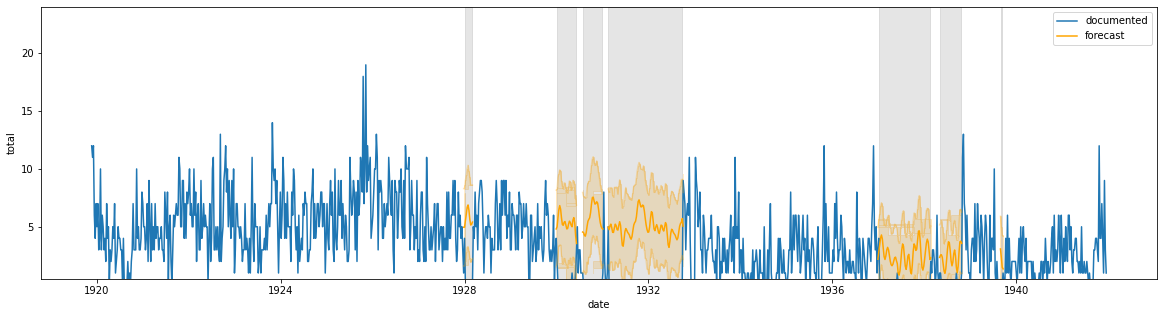

In [ ]:
plot_newsubs_weekly_forecast(uniqname_newsub_weekly_growth_forecasts, show_model=False, separate_model_decades=False, newmember_subscriptions_by_week=newmember_uniqname_subscriptions_by_week)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:47: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:47: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:47: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:47: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:47: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:47: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


<Figure size 432x288 with 0 Axes>

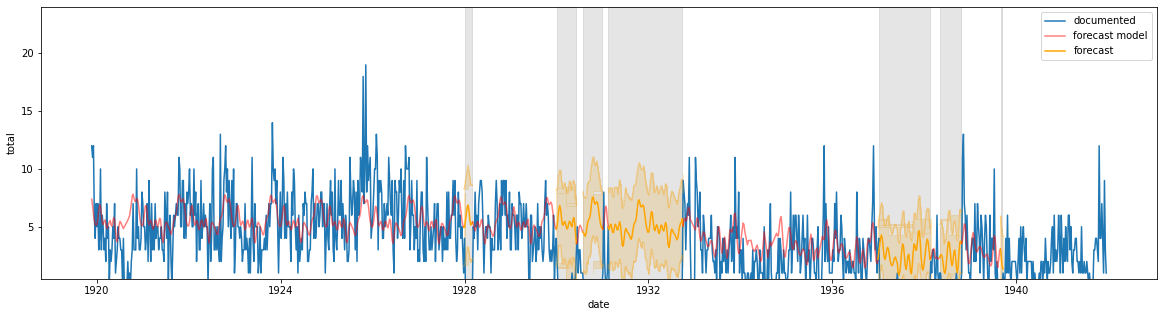

In [ ]:
plot_newsubs_weekly_forecast(uniqname_newsub_weekly_growth_forecasts, show_model=True, separate_model_decades=False, newmember_subscriptions_by_week=newmember_uniqname_subscriptions_by_week)


### summarize


In [ ]:
uniqname_newsub_member_total = len(subscription_uniqname_first_events.member_names.unique())
uniqname_newsub_member_total

3975

In [ ]:
uniqname_member_total = len(events_df.member_names.unique())
uniqname_member_total

4720

In [ ]:

aggregrate_missing_newsub_estimates(uniqname_newsub_weekly_growth_forecasts, newmember_subscriptions_by_week=newmember_uniqname_subscriptions_by_week, newsub_member_total=uniqname_newsub_member_total, member_total=uniqname_member_total)


gap overlap for 1928-03-04 00:00:00 is 3 days
gap overlap for 1930-06-08 00:00:00 is 0 days
gap overlap for 1931-01-04 00:00:00 is 3 days
gap overlap for 1932-10-02 00:00:00 is 0 days
gap overlap for 1938-02-20 00:00:00 is 3 days
gap overlap for 1938-10-23 00:00:00 is 4 days
gap overlap for 1939-09-17 00:00:00 is 2 days


missing estimates:
    897.0643818583792
    upper: 1563.588657234515
    lower: 283.1213191485815

  total unique members: 4720
  total members from first subscriptions: 3975
  estimated missing subscriptions: 897.06 (upper 1563.59, lower 283.12)
  estimated total subscriptions from logbooks: 4872.06 (upper 5538.59, lower 4258.12)
  total missing: 152 (upper 818, lower 0)
  estimated percent: 96.88 (upper 85.22, lower 110.85)
  


## recalculate Kevin's simpler missing member estimate


In [ ]:
total_accounts = len(events_df.member_uris.unique())
total_logbook_accounts = len(logbook_events_df.member_uris.unique())
total_logbook_events = logbook_events_df.shape[0]

# new member per logbook event
n_accounts_per_logbook_event = total_logbook_accounts / total_logbook_events

# estimated total number of logbook events
# from prophet:
#  13,955 events (upper 15,220; lower 12,358
# from KM estimate: 13,597

est_total_logbook_events = 13955
est_total_logbook_events_upper = 15220
est_total_logbook_events_lower = 12358


est_logbook_accounts = est_total_logbook_events * n_accounts_per_logbook_event
est_logbook_accounts_upper = est_total_logbook_events_upper * n_accounts_per_logbook_event
est_logbook_accounts_lower = est_total_logbook_events_lower * n_accounts_per_logbook_event


n_missing_accounts = int(est_logbook_accounts - total_accounts)
n_missing_accounts_upper = int(est_logbook_accounts_upper - total_accounts)
n_missing_accounts_lower = int(est_logbook_accounts_lower - total_accounts)


# how many accounts do we have 
percent_surviving_accounts = (total_accounts / est_logbook_accounts) * 100
percent_surviving_accounts_upper = (total_accounts / est_logbook_accounts_upper) * 100
percent_surviving_accounts_lower = (total_accounts / est_logbook_accounts_lower) * 100


print("""
total accounts: %d
total accounts from logbooks: %d:
total logbook events: %d
new member per logbook event: %.2f
est total members from logbooks: %.2f (upper %.2f, lower %.2f)
est missing accounts: %.2f (upper %.2f, lower %.2f)
percent covered: %.2f (upper %.2f, lower %.2f)
percent missing: 
""" % (
    total_accounts,
    total_logbook_accounts,
    total_logbook_events,
    n_accounts_per_logbook_event,
    # est total members
    est_logbook_accounts, est_logbook_accounts_upper, est_logbook_accounts_lower,
    n_missing_accounts, n_missing_accounts_upper, n_missing_accounts_lower,
    percent_surviving_accounts, percent_surviving_accounts_upper, percent_surviving_accounts_lower
))


total accounts: 5139
total accounts from logbooks: 4604:
total logbook events: 11601
new member per logbook event: 0.40
est total members from logbooks: 5538.21 (upper 6040.24, lower 4904.42)
est missing accounts: 399.00 (upper 901.00, lower -234.00)
percent covered: 92.79 (upper 85.08, lower 104.78)
percent missing: 



In [ ]:
len(events_df.member_uris.unique())

5139

In [ ]:
len(events_df.member_names.unique())  # use this one, since it includes titles and merges slightly fewer accounts

4720

In [ ]:
len(events_df.member_sort_names.unique())

4714

In [ ]:
def simple_missing_member_est_collapsed():
  # group by name instead of id
  total_accounts = len(events_df.member_names.unique())
  total_logbook_accounts = len(logbook_events_df.member_names.unique())
  total_logbook_events = logbook_events_df.shape[0]

  # new member per logbook event
  n_accounts_per_logbook_event = total_logbook_accounts / total_logbook_events

  # estimated total number of logbook events
  # from prophet:
  #  13,955 events (upper 15,220; lower 12,358
  # from KM estimate: 13,597

  est_total_logbook_events = 13955
  est_total_logbook_events_upper = 15220
  est_total_logbook_events_lower = 12358


  est_logbook_accounts = est_total_logbook_events * n_accounts_per_logbook_event
  est_logbook_accounts_upper = est_total_logbook_events_upper * n_accounts_per_logbook_event
  est_logbook_accounts_lower = est_total_logbook_events_lower * n_accounts_per_logbook_event


  n_missing_accounts = int(est_logbook_accounts - total_accounts)
  n_missing_accounts_upper = int(est_logbook_accounts_upper - total_accounts)
  n_missing_accounts_lower = int(est_logbook_accounts_lower - total_accounts)


  # how many accounts do we have 
  percent_surviving_accounts = (total_accounts / est_logbook_accounts) * 100
  percent_surviving_accounts_upper = (total_accounts / est_logbook_accounts_upper) * 100
  percent_surviving_accounts_lower = (total_accounts / est_logbook_accounts_lower) * 100


  print("""
  ** counting by unique name instead of member id**
  total accounts: %d
  total accounts from logbooks: %d:
  total logbook events: %d
  new member per logbook event: %.2f
  est total members from logbooks: %.2f (upper %.2f, lower %.2f)
  est missing accounts: %.2f (upper %.2f, lower %.2f)
  percent covered: %.2f (upper %.2f, lower %.2f)
  """ % (
      total_accounts,
      total_logbook_accounts,
      total_logbook_events,
      n_accounts_per_logbook_event,
      # est total members
      est_logbook_accounts, est_logbook_accounts_upper, est_logbook_accounts_lower,
      n_missing_accounts, n_missing_accounts_upper, n_missing_accounts_lower,
      percent_surviving_accounts, percent_surviving_accounts_upper, percent_surviving_accounts_lower
  ))


simple_missing_member_est_collapsed()


  ** counting by unique name instead of member id**
  total accounts: 4720
  total accounts from logbooks: 4200:
  total logbook events: 11601
  new member per logbook event: 0.36
  est total members from logbooks: 5052.24 (upper 5510.21, lower 4474.06)
  est missing accounts: 332.00 (upper 790.00, lower -245.00)
  percent covered: 93.42 (upper 85.66, lower 105.50)
  


In [ ]:
# why is Kevin's number for unique members different than mine? more than just shared accounts

members_df = pd.read_csv(csv_urls['members'])

In [ ]:
members_df.uri.describe()

count                                                  5235
unique                                                 5235
top       https://shakespeareandco.princeton.edu/members...
freq                                                      1
Name: uri, dtype: object

In [ ]:
events_df.member_uris.describe()

count                                                 35523
unique                                                 5139
top       https://shakespeareandco.princeton.edu/members...
freq                                                   1523
Name: member_uris, dtype: object

In [ ]:
events_df[events_df.member_uris.str.contains(';')].member_uris.describe()

count                                                   557
unique                                                   49
top       https://shakespeareandco.princeton.edu/members...
freq                                                    256
Name: member_uris, dtype: object

In [ ]:
# unique accounts from events + number of shared events
5139 + 49

5188

In [ ]:
# where is the difference between that number and the 5235 total from members dataset?

# missing borrowing activity

In [ ]:
# subset data for only those with complete start and end dates
date_events = events_df[(events_df.start_date.str.len() > 9) & (events_df.end_date.str.len() > 9)].copy()
# turn start/end dates into datetimes
date_events['start_datetime'] = pd.to_datetime(date_events.start_date, format='%Y-%m-%d', errors='ignore')
date_events['end_datetime'] = pd.to_datetime(date_events.end_date, format='%Y-%m-%d', errors='ignore')
date_events = date_events.sort_values(by=['start_datetime'])
date_events.head()

event_type  start_date  ... start_datetime end_datetime
671    Subscription  1919-11-17  ...     1919-11-17   1919-12-17
29915  Subscription  1919-11-17  ...     1919-11-17   1920-11-17
29914  Subscription  1919-11-17  ...     1919-11-17   1920-02-17
674          Borrow  1919-11-18  ...     1919-11-18   1919-11-28
29916  Subscription  1919-11-18  ...     1919-11-18   1920-05-18

[5 rows x 34 columns]

In [ ]:
# borrow events 
borrow_events = date_events[date_events.event_type == 'Borrow']

# subset data for subscription events with complete dates
subscription_events = date_events[date_events.event_type.isin(['Subscription', 'Renewal', 'Supplement'])].copy()

In [ ]:
# some subscriptions (~377) do not have subscription volume documented;
# subscription volume is 1 at minumim
subscription_events["subscription_volumes"] = subscription_events.subscription_volumes.apply(lambda x: x if pd.notna(x) else 1)

In [ ]:
# date range for subscriptions
earliest_date = date_events.start_datetime.iloc[0]
# end date for the last subscription
subs_end_date = subscription_events.end_datetime.max()

In [ ]:
# load members
members_df = pd.read_csv(csv_urls['members'])

# for now, use has card to identify borrows that belong to subscriptions (but this is approximate)
member_subs = subscription_events.copy()
member_subs[['first_member_uri','second_member_uri']] = member_subs.member_uris.str.split(';', expand=True)
# handle multiple member uris (joint accounts) in subscriptions by merging on the first one (has card should be same)
member_subs = pd.merge(left=member_subs, right=members_df, left_on="first_member_uri", right_on="uri")
member_subs = member_subs[member_subs.has_card]


In [ ]:
# make a copy of the dataframe so pandas won't complain about setting values on a slice
subscriptions_df = subscription_events.copy()

def borrows_within_sub(subscription):
  # identify and count any borrow events that *start* during this subscription
  # (do we want start or any overlap? start matters more when estimating book events)
  return len(borrow_events[(borrow_events.member_id == subscription.member_id) & 
              (subscription.start_date <= borrow_events.start_date) & (borrow_events.start_date <= subscription.end_date)])

subscriptions_df['documented_borrows'] = subscriptions_df.apply(borrows_within_sub, axis=1)
subscriptions_df.head()

event_type  start_date  ... end_datetime documented_borrows
671    Subscription  1919-11-17  ...   1919-12-17                  3
29915  Subscription  1919-11-17  ...   1920-11-17                  0
29914  Subscription  1919-11-17  ...   1920-02-17                  0
29916  Subscription  1919-11-18  ...   1920-05-18                  0
672    Subscription  1919-11-18  ...   1919-12-18                  1

[5 rows x 35 columns]

In [ ]:
# check — example subscriptions with no borrows
subscriptions_df[subscriptions_df.documented_borrows == 0].head()

event_type  start_date  ... end_datetime documented_borrows
29915  Subscription  1919-11-17  ...   1920-11-17                  0
29914  Subscription  1919-11-17  ...   1920-02-17                  0
29916  Subscription  1919-11-18  ...   1920-05-18                  0
677    Subscription  1919-11-18  ...   1919-12-18                  0
681    Subscription  1919-11-20  ...   1920-05-20                  0

[5 rows x 35 columns]

In [ ]:
# check — example subscriptions with at least one borrow
subscriptions_df[subscriptions_df.documented_borrows > 0].head()

event_type  start_date  ... end_datetime documented_borrows
671  Subscription  1919-11-17  ...   1919-12-17                  3
672  Subscription  1919-11-18  ...   1919-12-18                  1
676  Subscription  1919-11-18  ...   1919-12-18                  4
679  Subscription  1919-11-19  ...   1920-05-19                 13
688  Subscription  1919-11-25  ...   1920-02-25                 16

[5 rows x 35 columns]

In [ ]:
# identify the subset of subscriptions with at least one borrow event
subs_with_borrows = subscriptions_df[subscriptions_df.documented_borrows > 0]

In [ ]:
# identify borrow events that fall within a subscription
borrow_events_df = borrow_events.copy()

def borrow_within_subscription(borrow):
  return bool(len(subscriptions_df[(subscriptions_df.member_id == borrow.member_id) & 
              (subscriptions_df.start_date <= borrow.start_date) &
              (subscriptions_df.end_date >= borrow.start_date)]))

borrow_events_df['within_subscription'] = borrow_events_df.apply(borrow_within_subscription, axis=1)


In [ ]:
# check to confirm
borrow_events_df[~borrow_events_df.within_subscription]

event_type  start_date  ... end_datetime within_subscription
768       Borrow  1920-01-12  ...   1920-01-22               False
779       Borrow  1920-01-22  ...   1920-03-13               False
830       Borrow  1920-03-13  ...   1920-04-17               False
865       Borrow  1920-04-13  ...   1920-04-19               False
863       Borrow  1920-04-13  ...   1921-04-22               False
...          ...         ...  ...          ...                 ...
29903     Borrow  1961-06-30  ...   1961-10-04               False
29904     Borrow  1961-06-30  ...   1961-10-04               False
29905     Borrow  1961-06-30  ...   1961-10-04               False
29908     Borrow  1961-10-04  ...   1962-03-21               False
29907     Borrow  1961-10-04  ...   1962-03-21               False

[2497 rows x 35 columns]

In [ ]:
borrows_within_subscriptions = borrow_events_df[borrow_events_df.within_subscription]

In [ ]:
from datetime import date, timedelta
# arbritrary end date while testing
#end_day = date(1925, 6, 1)
# go through end of last subscription end date
#end_day = subs_end_date
one_day = timedelta(days=1)
# start with the earliest start date
day = date_events.start_datetime.iloc[0]

dates = []
books_out = []
borrow_events_perday = []
subscription_vols = []
card_subscription_vols = []
book_subscription_vols = []


while day < subs_end_date:
    dates.append(day)
    # get total number of borrowing events spanning this date; include start date, exclude end (to avoid double counting)
    books_out.append(len(borrows_within_subscriptions[(borrows_within_subscriptions.start_datetime <= day) & (borrows_within_subscriptions.end_datetime > day)]))
    # total number of volumes from active subscriptions for this date
    subscription_vols.append(subscription_events[(subscription_events.start_datetime <= day) & (day < subscription_events.end_datetime)].subscription_volumes.sum())
    # total number of volumes from subscriptions for members with extant cards
    card_subscription_vols.append(member_subs[(member_subs.start_datetime <= day) & (day < member_subs.end_datetime)].subscription_volumes.sum())

    # total number of volumes from subscriptions for subscriptions with at least one borrow event
    book_subscription_vols.append(subs_with_borrows[(subs_with_borrows.start_datetime <= day) & (day < subs_with_borrows.end_datetime)].subscription_volumes.sum())

    # count actual borrow events that started on this date
    borrow_events_perday.append(len(borrow_events[borrow_events.start_datetime == day]))

    day += one_day

borrowing_df  = pd.DataFrame()
borrowing_df['date'] = dates
borrowing_df['books_out'] = books_out
borrowing_df['borrow_event_count'] = borrow_events_perday
borrowing_df['subscription_volumes'] = subscription_vols
borrowing_df['card_subscription_volumes'] = card_subscription_vols
borrowing_df['book_subscription_volumes'] = book_subscription_vols
borrowing_df

date  ...  book_subscription_volumes
0    1919-11-17  ...                        1.0
1    1919-11-18  ...                        4.0
2    1919-11-19  ...                        5.0
3    1919-11-20  ...                        5.0
4    1919-11-21  ...                        5.0
...         ...  ...                        ...
8321 1942-08-29  ...                        1.0
8322 1942-08-30  ...                        1.0
8323 1942-08-31  ...                        1.0
8324 1942-09-01  ...                        1.0
8325 1942-09-02  ...                        1.0

[8326 rows x 6 columns]

In [ ]:
# where do card member subs and book subs differ?
borrowing_df[borrowing_df.card_subscription_volumes != borrowing_df.book_subscription_volumes]

date  ...  book_subscription_volumes
5    1919-11-22  ...                        5.0
6    1919-11-23  ...                        5.0
7    1919-11-24  ...                        5.0
8    1919-11-25  ...                        6.0
9    1919-11-26  ...                        6.0
...         ...  ...                        ...
8077 1941-12-28  ...                       27.0
8078 1941-12-29  ...                       26.0
8079 1941-12-30  ...                       25.0
8080 1941-12-31  ...                       25.0
8081 1942-01-01  ...                       25.0

[6743 rows x 6 columns]

In [ ]:
# what is the ratio of subscriptions to borrow events?
borrowing_df['book_events_per_subscription_vol'] = borrowing_df.apply(lambda x: x.borrow_event_count / x.book_subscription_volumes, axis=1)
borrowing_df

date  ...  book_events_per_subscription_vol
0    1919-11-17  ...                              0.00
1    1919-11-18  ...                              0.75
2    1919-11-19  ...                              0.40
3    1919-11-20  ...                              0.00
4    1919-11-21  ...                              0.00
...         ...  ...                               ...
8321 1942-08-29  ...                              0.00
8322 1942-08-30  ...                              0.00
8323 1942-08-31  ...                              0.00
8324 1942-09-01  ...                              0.00
8325 1942-09-02  ...                              0.00

[8326 rows x 7 columns]

In [ ]:
borrowing_df['book_events_per_subscription_vol'].describe()

count    8326.000000
mean        0.094945
std         0.142912
min         0.000000
25%         0.000000
50%         0.069767
75%         0.146341
max         6.000000
Name: book_events_per_subscription_vol, dtype: float64

In [ ]:
# aggregate subscriptions by day so that we can get a weekly/monthly average of the _total_ subscription volumes

borrowing_daily = borrowing_df.groupby([pd.Grouper(key='date', freq='D')]) \
  .agg({'book_subscription_volumes':'sum',
        'borrow_event_count': 'sum', 'card_subscription_volumes':'sum', 
        'book_subscription_volumes': 'sum', 
        'subscription_volumes': 'sum'}).reset_index()
borrowing_daily.head(13)

date  ...  subscription_volumes
0  1919-11-17  ...                   3.0
1  1919-11-18  ...                   9.0
2  1919-11-19  ...                  10.0
3  1919-11-20  ...                  11.0
4  1919-11-21  ...                  13.0
5  1919-11-22  ...                  14.0
6  1919-11-23  ...                  14.0
7  1919-11-24  ...                  16.0
8  1919-11-25  ...                  17.0
9  1919-11-26  ...                  19.0
10 1919-11-27  ...                  19.0
11 1919-11-28  ...                  20.0
12 1919-11-29  ...                  27.0

[13 rows x 5 columns]

In [ ]:
# counting by day is too small, we need to aggregate a bit; let's try weekly
# borrowing_weekly = borrowing_df.groupby([pd.Grouper(key='date', freq='W')]).agg({'book_subscription_volumes':'mean','borrow_event_count': 'sum', 'card_subscription_volumes':'mean', 'book_subscription_volumes': 'mean', 'subscription_volumes': 'mean'})
# borrowing_weekly = borrowing_weekly.reset_index()
# borrowing_weekly

# take an average of the total subscription volumes by day; count up all the borrow events during the week
# (or do we actually want the maximum?!)
# borrowing_weekly = borrowing_daily.groupby([pd.Grouper(key='date', freq='W')]).agg({'book_subscription_volumes':'mean','borrow_event_count': 'sum', 'card_subscription_volumes':'mean', 'book_subscription_volumes': 'mean', 'subscription_volumes': 'mean'})
borrowing_weekly = borrowing_daily.groupby([pd.Grouper(key='date', freq='W')]).agg({'book_subscription_volumes':'max','borrow_event_count': 'sum', 'card_subscription_volumes':'max', 'subscription_volumes': 'max'})
borrowing_weekly = borrowing_weekly.reset_index()
borrowing_weekly


date  ...  subscription_volumes
0    1919-11-23  ...                  14.0
1    1919-11-30  ...                  27.0
2    1919-12-07  ...                  41.0
3    1919-12-14  ...                  47.0
4    1919-12-21  ...                  48.0
...         ...  ...                   ...
1185 1942-08-09  ...                   1.0
1186 1942-08-16  ...                   1.0
1187 1942-08-23  ...                   1.0
1188 1942-08-30  ...                   1.0
1189 1942-09-06  ...                   1.0

[1190 rows x 5 columns]

In [ ]:
borrowing_weekly.borrow_event_count.describe()

count    1190.000000
mean       16.490756
std        12.728959
min         0.000000
25%         8.000000
50%        13.000000
75%        23.000000
max        84.000000
Name: borrow_event_count, dtype: float64

In [ ]:
borrowing_weekly['ratio'] = borrowing_weekly.apply(lambda row: row.borrow_event_count / row.book_subscription_volumes, axis=1)
borrowing_weekly.ratio.describe()

count    1190.000000
mean        0.642890
std         0.364388
min         0.000000
25%         0.428571
50%         0.636364
75%         0.833333
max         6.000000
Name: ratio, dtype: float64

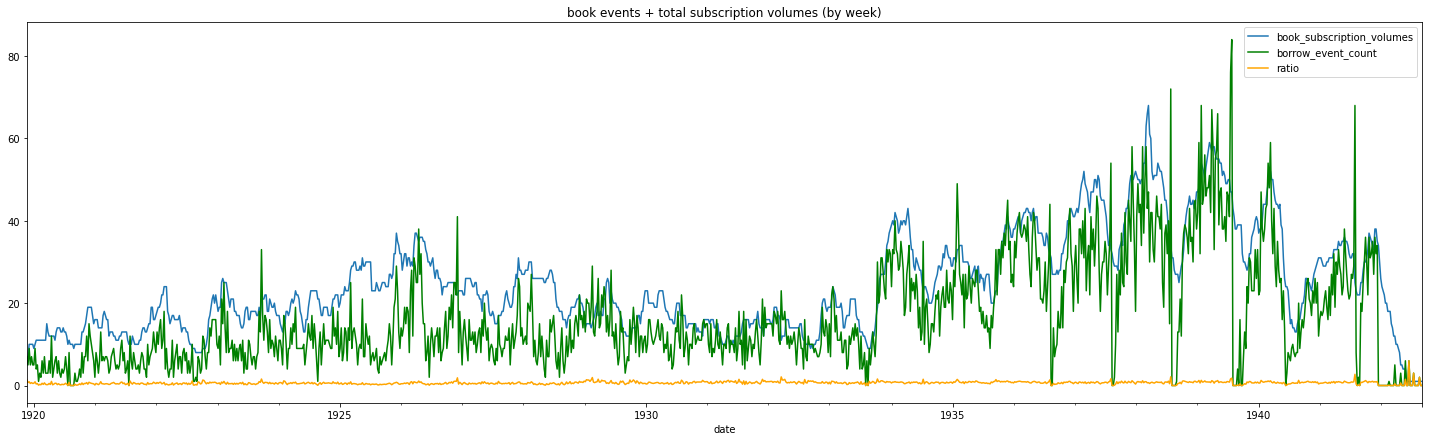

In [ ]:

# get current axis so we can plot two series on the same axis
ax = plt.gca()

borrowing_weekly.plot(kind='line',x='date',y='book_subscription_volumes',ax=ax, figsize=(25,7), title='book events + total subscription volumes (by week)')
borrowing_weekly.plot(kind='line',x='date',y='borrow_event_count', color='green', ax=ax)
borrowing_weekly.plot(kind='line',x='date',y='ratio', color='orange', ax=ax)


plt.show()


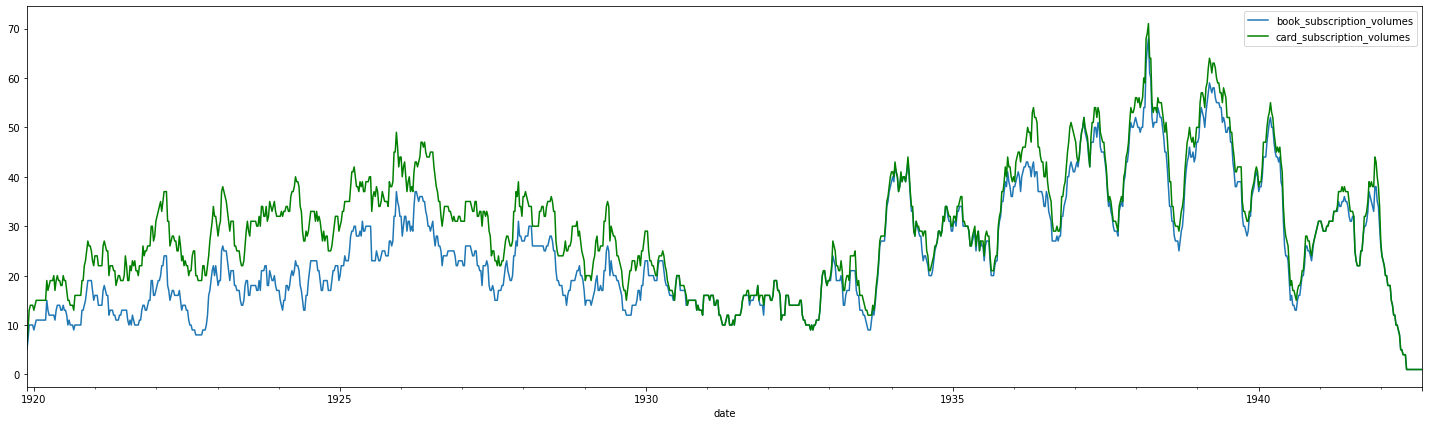

In [ ]:
# how different are card volumes and book subscription volumes?

ax = plt.gca()
borrowing_weekly.plot(kind='line',x='date',y='book_subscription_volumes',ax=ax, figsize=(25,7))
borrowing_weekly.plot(kind='line',x='date',y='card_subscription_volumes', color='green', ax=ax)

plt.show()

In [ ]:
# let's try aggregating by month
# borrowing_monthly = borrowing_df.groupby([pd.Grouper(key='date', freq='MS')]).agg({'book_subscription_volumes':'mean','borrow_event_count': 'sum'})
# borrowing_monthly = borrowing_monthly.reset_index()
# borrowing_monthly

# borrowing_monthly = borrowing_daily.groupby([pd.Grouper(key='date', freq='MS')]).agg({'book_subscription_volumes':'mean','borrow_event_count': 'sum'})

borrowing_monthly = borrowing_daily.groupby([pd.Grouper(key='date', freq='MS')]).agg({'book_subscription_volumes':'max','borrow_event_count': 'sum'})
borrowing_monthly = borrowing_monthly.reset_index()
borrowing_monthly


date  book_subscription_volumes  borrow_event_count
0   1919-11-01                        7.0                  12
1   1919-12-01                       10.0                  30
2   1920-01-01                       11.0                  20
3   1920-02-01                       11.0                  14
4   1920-03-01                       15.0                  18
..         ...                        ...                 ...
270 1942-05-01                        5.0                   6
271 1942-06-01                        1.0                   6
272 1942-07-01                        1.0                   3
273 1942-08-01                        1.0                   2
274 1942-09-01                        1.0                   0

[275 rows x 3 columns]

In [ ]:
borrowing_monthly.borrow_event_count.describe()

count    275.000000
mean      71.360000
std       50.290302
min        0.000000
25%       38.500000
50%       53.000000
75%       99.500000
max      251.000000
Name: borrow_event_count, dtype: float64

In [ ]:
borrowing_monthly['ratio'] = borrowing_monthly.apply(lambda row: row.borrow_event_count / row.book_subscription_volumes, axis=1)
borrowing_monthly.ratio.describe()

count    275.000000
mean       2.600836
std        0.985389
min        0.000000
25%        1.935417
50%        2.625000
75%        3.264231
max        6.000000
Name: ratio, dtype: float64

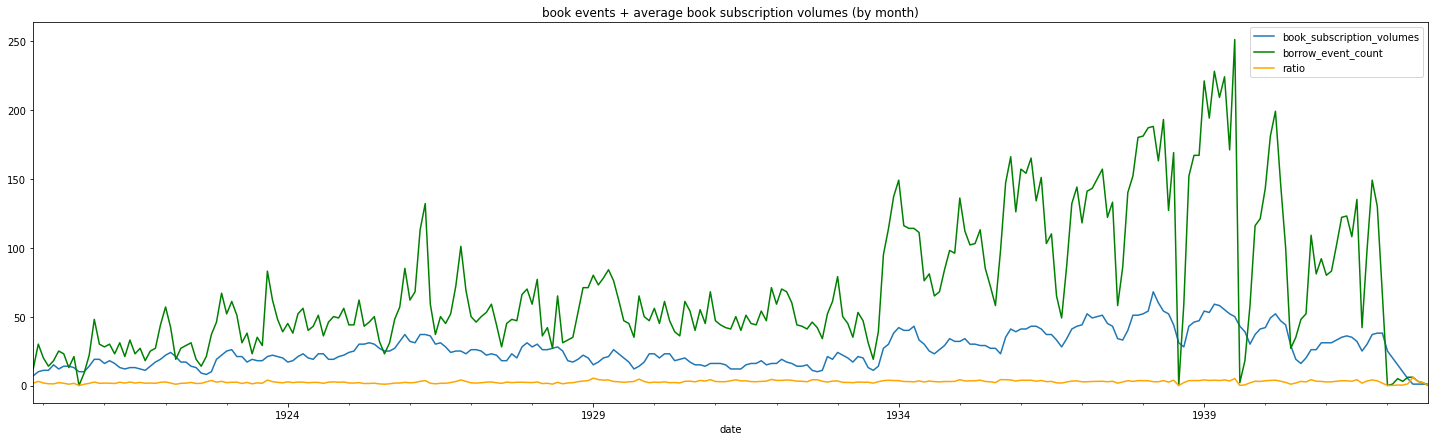

In [ ]:
# get current axis so we can plot two series on the same axis
ax = plt.gca()

borrowing_monthly.plot(kind='line',x='date',y='book_subscription_volumes',ax=ax, figsize=(25,7), title='book events + average book subscription volumes (by month)')
borrowing_monthly.plot(kind='line',x='date',y='borrow_event_count', color='green', ax=ax)
borrowing_monthly.plot(kind='line',x='date',y='ratio', color='orange', ax=ax)


plt.show()

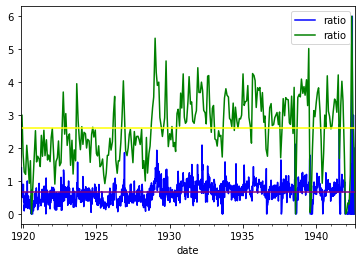

In [ ]:
# if we plot just the ratio, how stable is it?
ax = plt.gca()

borrowing_weekly.plot(kind='line',x='date',y='ratio', color='blue', ax=ax)
borrowing_monthly.plot(kind='line',x='date',y='ratio', color='green', ax=ax)

# monthly ratio average
#plt.axhline(y=2.858, color='yellow', linestyle='-')  # 2.8 is ratio when we use average subscription
plt.axhline(y=2.6, color='yellow', linestyle='-')  # 2.6 is ratio when we use max # subscriptions


# weekly ratio average
plt.axhline(y=0.663, color='purple', linestyle='-')  # weekly ratio doesn't change noticeably when we switch from mean to max

plt.show()

In [ ]:
# ok, now apply our ratio to the non-book subscription volumes
borrowing_weekly['non_book_subs_vols'] = borrowing_weekly.apply(lambda row: row.subscription_volumes - row.book_subscription_volumes, axis=1)
borrowing_weekly.head()

date  book_subscription_volumes  ...     ratio  non_book_subs_vols
0 1919-11-23                        5.0  ...  1.400000                 9.0
1 1919-11-30                        7.0  ...  0.714286                20.0
2 1919-12-07                       10.0  ...  0.900000                31.0
3 1919-12-14                       10.0  ...  0.500000                37.0
4 1919-12-21                       10.0  ...  0.700000                38.0

[5 rows x 7 columns]

In [ ]:
borrow_events_per_subsvol = borrowing_weekly.ratio.mean()
borrow_events_per_subsvol

0.6428904216675606

In [ ]:
# find an example
borrowing_weekly[borrowing_weekly.ratio >= 0.6][borrowing_weekly.ratio <= 0.65]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


date  book_subscription_volumes  ...     ratio  non_book_subs_vols
15   1920-03-07                       11.0  ...  0.636364                71.0
47   1920-10-17                       13.0  ...  0.615385                67.0
54   1920-12-05                       19.0  ...  0.631579               107.0
73   1921-04-17                       13.0  ...  0.615385               134.0
83   1921-06-26                       13.0  ...  0.615385               120.0
...         ...                        ...  ...       ...                 ...
1082 1940-08-18                       13.0  ...  0.615385                21.0
1105 1941-01-26                       29.0  ...  0.620690                54.0
1108 1941-02-16                       30.0  ...  0.633333                54.0
1121 1941-05-18                       35.0  ...  0.628571                64.0
1171 1942-05-03                        5.0  ...  0.600000                 1.0

[81 rows x 7 columns]

In [ ]:
borrowing_weekly['estimated_borrow_events'] = borrowing_weekly.non_book_subs_vols.apply(lambda x: x * borrow_events_per_subsvol)
borrowing_weekly

date  ...  estimated_borrow_events
0    1919-11-23  ...                 5.786014
1    1919-11-30  ...                12.857808
2    1919-12-07  ...                19.929603
3    1919-12-14  ...                23.786946
4    1919-12-21  ...                24.429836
...         ...  ...                      ...
1185 1942-08-09  ...                 0.000000
1186 1942-08-16  ...                 0.000000
1187 1942-08-23  ...                 0.000000
1188 1942-08-30  ...                 0.000000
1189 1942-09-06  ...                 0.000000

[1190 rows x 8 columns]

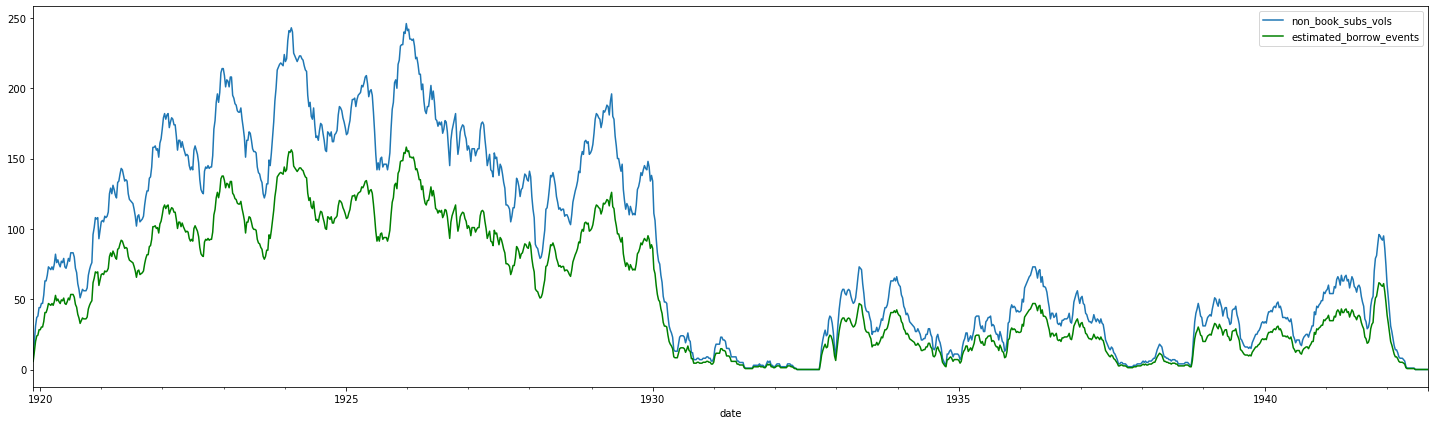

In [ ]:
# plot with our estimates
ax = plt.gca()

borrowing_weekly.plot(kind='line',x='date',y='non_book_subs_vols',ax=ax, figsize=(25,7))
borrowing_weekly.plot(kind='line',x='date',y='estimated_borrow_events', color='green', ax=ax)


plt.show()

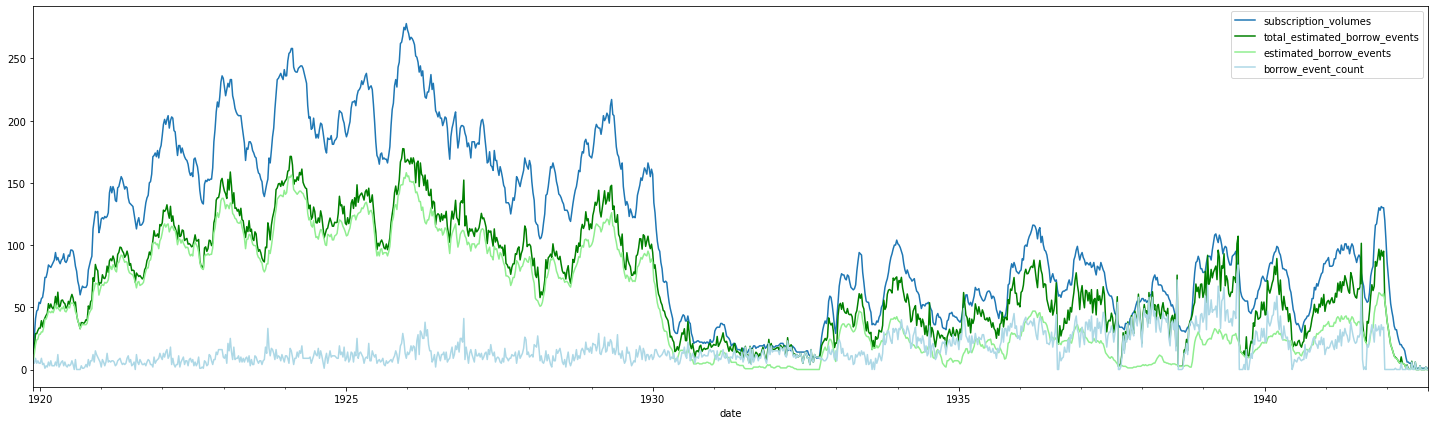

In [ ]:
# now combine and plot the total

ax = plt.gca()
# tally up our estimate with the actual event count
borrowing_weekly['total_estimated_borrow_events'] = borrowing_weekly.apply(lambda row: row.estimated_borrow_events + row.borrow_event_count, axis=1)


borrowing_weekly.plot(kind='line',x='date',y='subscription_volumes',ax=ax, figsize=(25,7))
borrowing_weekly.plot(kind='line',x='date',y='total_estimated_borrow_events', color='green', ax=ax)
borrowing_weekly.plot(kind='line',x='date',y='estimated_borrow_events', color='lightgreen', ax=ax)
borrowing_weekly.plot(kind='line',x='date',y='borrow_event_count', color='lightblue', ax=ax)


plt.show()

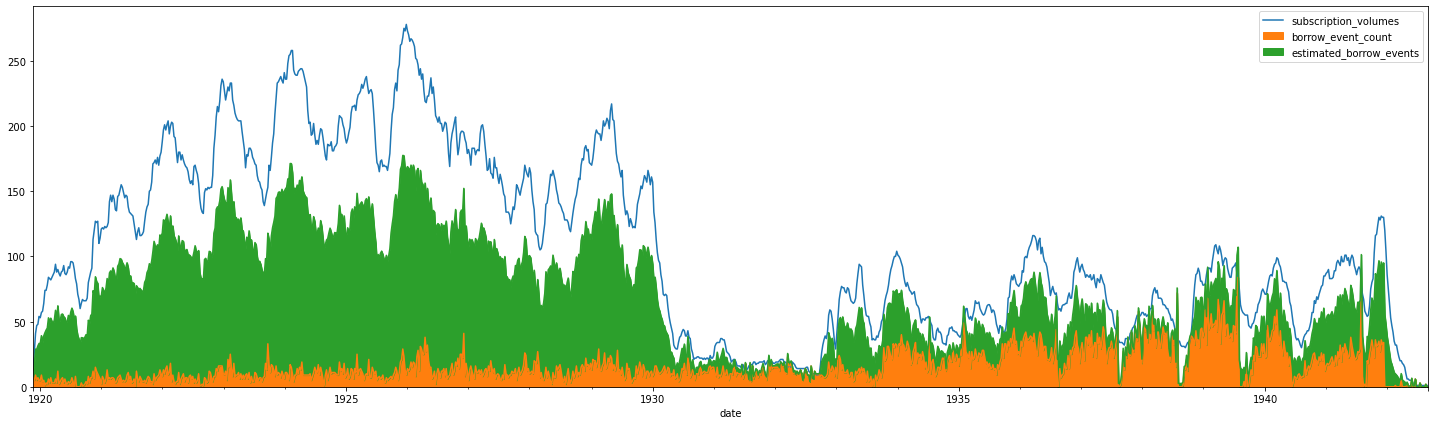

In [ ]:
ax = plt.gca()
# total subscriptoin volumes
borrowing_weekly.plot(kind='line',x='date',y='subscription_volumes',ax=ax, figsize=(25,7))
# stacked area chart of actual borrows and estimated missing 
borrowing_weekly[['date', 'borrow_event_count', 'estimated_borrow_events']].plot.area(x='date', stacked=True, ax=ax)
# line plot the total over the stack (not really helpful)
# borrowing_weekly.plot(kind='line',x='date',y='total_estimated_borrow_events', color='yellow', ax=ax)




In [ ]:
# how about some numbers?

# total number of estimated missing borrow events based on known subscriptions
est_total_missing_borrows = borrowing_weekly.estimated_borrow_events.sum()
est_total_missing_borrows

63330.49254804972

In [ ]:
# how many borrow events did we use to generate our estimate? 
total_borrows_used_to_estimate =  borrows_within_subscriptions.shape[0]
total_borrows_used_to_estimate

17292

In [ ]:
all_borrows = events_df[events_df.event_type == 'Borrow']
all_borrows

event_type start_date  ...       member_id                         item_id
2         Borrow       1922  ...            rhys                  conrad-typhoon
8         Borrow       1923  ...   lanux-eyre-de                 woolf-night-day
12        Borrow       1924  ...            tery                     james-joyce
13        Borrow       1924  ...            tery   freeman-portrait-george-moore
22        Borrow       1926  ...    macleish-ada              stern-tents-israel
...          ...        ...  ...             ...                             ...
35457     Borrow        NaN  ...  hommel-bernard                     heine-poems
35460     Borrow        NaN  ...  hommel-bernard  cowley-exiles-return-narrative
35463     Borrow        NaN  ...  hommel-bernard       wilson-axels-castle-study
35464     Borrow        NaN  ...  hommel-bernard             city-dreadful-night
35485     Borrow        NaN  ...  hommel-bernard            joyce-pomes-penyeach

[21059 rows x 32 columns]

In [ ]:
all_borrows['year'] = all_borrows.start_date.apply(lambda x: x.split('-')[0] if pd.notna(x) else None)
all_borrows.year.unique()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


array(['1922', '1923', '1924', '1926', '1929', '1931', '1934', '1936',
       '1937', '1938', '1940', '1942', '1944', '1946', '1948', '1952',
       '1955', '1956', '1960', '1920', '1921', '1927', '1928', '1932',
       '1935', None, '1939', '1943', '1945', '1947', '1954', '1961', '',
       '1919', '1925', '1930', '1933', '1941', '1949', '1950', '1951',
       '1953', '1957', '1958', '1962'], dtype=object)

In [ ]:
official_borrows = all_borrows[all_borrows.year < "1942"]
official_borrows

event_type  start_date  ...                        item_id  year
2         Borrow        1922  ...                 conrad-typhoon  1922
8         Borrow        1923  ...                woolf-night-day  1923
12        Borrow        1924  ...                    james-joyce  1924
13        Borrow        1924  ...  freeman-portrait-george-moore  1924
22        Borrow        1926  ...             stern-tents-israel  1926
...          ...         ...  ...                            ...   ...
29452     Borrow  1941-12-12  ...         bennett-old-wives-tale  1941
29458     Borrow  1941-12-12  ...              de-la-roche-house  1941
29459     Borrow  1941-12-12  ...                  views-reviews  1941
29460     Borrow  1941-12-12  ...          thackeray-vanity-fair  1941
29461     Borrow  1941-12-13  ...           wells-mankind-making  1941

[20597 rows x 33 columns]

In [ ]:
# how many borrows do we have total? (with/without dates)
# (todo: exclude after last subscription ?)
# members_added = members_added[members_added['date'] < datetime(1942, 1, 1)]

total_borrows = events_df[events_df.event_type == 'Borrow'].shape[0]
total_borrows 

21059

In [ ]:
total_official_borrows = official_borrows.shape[0]
total_official_borrows

20597

In [ ]:
total_borrows - total_official_borrows

462

In [ ]:
total_official_borrows / total_borrows

0.9780616363550027

In [ ]:
# what about other book activity?
book_events = events_df[events_df.item_uri.notna()]
total_book_events = book_events.shape[0]
total_book_events

22484

In [ ]:
total_official_borrows / total_book_events

0.9160736523750223

In [ ]:
total_official_borrows - total_borrows_used_to_estimate  

3305

In [ ]:
# estimated total based on subscriptions
est_total = est_total_missing_borrows + total_borrows_used_to_estimate
est_total

80622.49254804972

In [ ]:
total_official_borrows / est_total


0.2554746119728873

In [ ]:
# how hard to report by decade? 